In [71]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os
import pandas as pd
from pyevtk.hl import gridToVTK
import sys
import threading
import time
import yaml

VECTOR-POTENTIAL VORTICITY FORMULATION

Written by Mr A. J. Brierley

Centre for Computational Engineering Sciences (CES)
Cranfield University
Bedfordshire
UK

adam.brierley@cranfield.ac.uk

Last update: 18th August 2025

In [72]:
# Enable in-line plot displays in Jupyter Notebook
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [73]:
# Enable LaTeX rendering
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [74]:
# %matplotlib notebook

In [75]:
# Results folder
results_folder = 'results'
os.makedirs(results_folder, exist_ok=True)  # Create folder if does not exist

In [76]:
# Wall time 
elapsed_time = 0

In [77]:
def timer():
    global elapsed_time
    start = time.time()
    while True:
        elapsed_time = time.time() - start
        time.sleep(1)

In [78]:
threading.Thread(target=timer, daemon=True).start()

In [79]:
# Open and read the input parameters
with open('config.yaml', 'r') as f:
    config = yaml.safe_load(f)

In [80]:
# Grid settings
nx = config['nx']
ny = config['ny']
nz = config['nz']
Lx = config['Lx']
Ly = config['Ly']
Lz = config['Lz']
dx = Lx/(nx-1)
dy = Ly/(ny-1)
dz = Lz/(nz-1)

In [81]:
# Physical parameters
nu = config['nu']
Ut = config['Ut']
Re = Ut*Lx/nu

In [82]:
print()
print('THE VECTOR-POTENTIAL AND VORTICITY FORMULATION FOR THE DRIVEN CUBE')
print()
print('---------------------')
print(f"Re = {Re}")
print(f'Ut = {Ut}')
print(f"nx = {nx}")


THE VECTOR-POTENTIAL AND VORTICITY FORMULATION FOR THE DRIVEN CUBE

---------------------
Re = 100.0
Ut = 5.0
nx = 21


In [83]:
# Initialise arrays
ψx0 = np.zeros([nx,ny,nz])
ψy0 = np.zeros([nx,ny,nz])
ψz0 = np.zeros([nx,ny,nz])

In [84]:
Ωx0 = np.zeros([nx,ny,nz])
Ωy0 = np.zeros([nx,ny,nz])
Ωz0 = np.zeros([nx,ny,nz])

In [85]:
u0 = np.zeros([nx,ny,nz])
v0 = np.zeros([nx,ny,nz])
w0 = np.zeros([nx,ny,nz])

In [86]:
div_vel = np.zeros([nx,ny,nz])
div_Ω = np.zeros([nx,ny,nz])

---------------------------------------------
VECTOR-POTENTIAL (ψ) BOUNDARY CONDITIONS
---------------------------------------------
according to Tokunaga (1992),

In [87]:
# Left wall
ψx0[0,1:ny-1,1:nz-1] = ψx0[1,1:ny-1,1:nz-1]
ψy0[0,1:ny-1,1:nz-1] = 0.0
ψz0[0,1:ny-1,1:nz-1] = 0.0

In [88]:
# Right wall
ψx0[nx-1,1:ny-1,1:nz-1] = ψx0[nx-2,1:ny-1,1:nz-1]
ψy0[nx-1,1:ny-1,1:nz-1] = 0.0
ψz0[nx-1,1:ny-1,1:nz-1] = 0.0

In [89]:
# Front wall
ψx0[1:nx-1,1:ny-1,0] = 0.0
ψy0[1:nx-1,1:ny-1,0] = 0.0
ψz0[1:nx-1,1:ny-1,0] = ψz0[1:nx-1,1:ny-1,1]

In [90]:
# Back wall
ψx0[1:nx-1,1:ny-1,nz-1] = 0.0
ψy0[1:nx-1,1:ny-1,nz-1] = 0.0
ψz0[1:nx-1,1:ny-1,nz-1] = ψz0[1:nx-1,1:ny-1,nz-2]

In [91]:
# Bottom wall
ψx0[1:nx-1,0,1:nz-1] = 0.0
ψy0[1:nx-1,0,1:nz-1] = ψy0[1:nx-1,1,1:nz-1]
ψz0[1:nx-1,0,1:nz-1] = 0.0

In [92]:
# Top wall
ψx0[1:nx-1,ny-1,1:nz-1] = 0.0
ψy0[1:nx-1,ny-1,1:nz-1] = ψy0[1:nx-1,ny-2,1:nz-1]
ψz0[1:nx-1,ny-1,1:nz-1] = 0.0

Vector potential edge points

In [93]:
# y direction edges
ψx0[0,1:ny-1,0] = (ψx0[1,1:ny-1,0] + ψx0[0,1:ny-1,1])/2.0                    # Front left 
ψy0[0,1:ny-1,0] = (ψy0[1,1:ny-1,0] + ψy0[0,1:ny-1,1])/2.0
ψz0[0,1:ny-1,0] = (ψz0[1,1:ny-1,0] + ψz0[0,1:ny-1,1])/2.0
ψx0[nx-1,1:ny-1,0] = (ψx0[nx-2,1:ny-1,0] + ψx0[nx-1,1:ny-1,1])/2.0            # Front right
ψy0[nx-1,1:ny-1,0] = (ψy0[nx-2,1:ny-1,0] + ψy0[nx-1,1:ny-1,1])/2.0
ψz0[nx-1,1:ny-1,0] = (ψz0[nx-2,1:ny-1,0] + ψz0[nx-1,1:ny-1,1])/2.0
ψx0[nx-1,1:ny-1,nz-1] = (ψx0[nx-1,1:ny-1,nz-2] + ψx0[nx-2,1:ny-1,nz-1])/2.0  # Back right
ψy0[nx-1,1:ny-1,nz-1] = (ψy0[nx-1,1:ny-1,nz-2] + ψy0[nx-2,1:ny-1,nz-1])/2.0
ψz0[nx-1,1:ny-1,nz-1] = (ψz0[nx-1,1:ny-1,nz-2] + ψz0[nx-2,1:ny-1,nz-1])/2.0
ψx0[0,1:ny-1,nz-1] = (ψx0[1,1:ny-1,nz-1] + ψx0[0,1:ny-1,nz-2])/2.0           # Back-left edge
ψy0[0,1:ny-1,nz-1] = (ψy0[1,1:ny-1,nz-1] + ψy0[0,1:ny-1,nz-2])/2.0
ψz0[0,1:ny-1,nz-1] = (ψz0[1,1:ny-1,nz-1] + ψz0[0,1:ny-1,nz-2])/2.0

In [94]:
# z direction edges
ψx0[0,0,1:nz-1] = (ψx0[1,0,1:nz-1] + ψx0[0,1,1:nz-1])/2.0                            # Bottom-left edge
ψy0[0,0,1:nz-1] = (ψy0[1,0,1:nz-1] + ψy0[0,1,1:nz-1])/2.0        
ψz0[0,0,1:nz-1] = (ψz0[1,0,1:nz-1] + ψz0[0,1,1:nz-1])/2.0
ψx0[nx-1,0,1:nz-1] = (ψx0[nx-2,0,1:nz-1] + ψx0[nx-1,1,1:nz-1])/2.0                   # Bottom-right edge
ψy0[nx-1,0,1:nz-1] = (ψy0[nx-2,0,1:nz-1] + ψy0[nx-1,1,1:nz-1])/2.0        
ψz0[nx-1,0,1:nz-1] = (ψz0[nx-2,0,1:nz-1] + ψz0[nx-1,1,1:nz-1])/2.0
ψx0[nx-1,ny-1,1:nz-1] = (ψx0[nx-2,ny-1,1:nz-1] + ψx0[nx-1,ny-2,1:nz-1])/2.0          # Top-right edge
ψy0[nx-1,ny-1,1:nz-1] = (ψy0[nx-2,ny-1,1:nz-1] + ψy0[nx-1,ny-2,1:nz-1])/2.0        
ψz0[nx-1,ny-1,1:nz-1] = (ψz0[nx-2,ny-1,1:nz-1] + ψz0[nx-1,ny-2,1:nz-1])/2.0
ψx0[0,ny-1,1:nz-1] = (ψx0[0,ny-2,1:nz-1] + ψx0[1,ny-1,1:nz-1])/2.0                   # Top-left edge
ψy0[0,ny-1,1:nz-1] = (ψy0[0,ny-2,1:nz-1] + ψy0[1,ny-1,1:nz-1])/2.0        
ψz0[0,ny-1,1:nz-1] = (ψz0[0,ny-2,1:nz-1] + ψz0[1,ny-1,1:nz-1])/2.0

In [95]:
# x direction edges
ψx0[1:nx-1,0,0] = (ψx0[1:nx-1,1,0] + ψx0[1:nx-1,0,1])/2.0                            # Front-bottom edge
ψy0[1:nx-1,0,0] = (ψy0[1:nx-1,1,0] + ψy0[1:nx-1,0,1])/2.0        
ψz0[1:nx-1,0,0] = (ψz0[1:nx-1,1,0] + ψz0[1:nx-1,0,1])/2.0
ψx0[1:nx-1,0,nz-1] = (ψx0[1:nx-1,1,nz-1] + ψx0[1:nx-1,0,nz-2])/2.0                   # Back-bottom edge
ψy0[1:nx-1,0,nz-1] = (ψy0[1:nx-1,1,nz-1] + ψy0[1:nx-1,0,nz-2])/2.0         
ψz0[1:nx-1,0,nz-1] = (ψz0[1:nx-1,1,nz-1] + ψz0[1:nx-1,0,nz-2])/2.0 
ψx0[1:nx-1,ny-1,0] = (ψx0[1:nx-1,ny-1,1] + ψx0[1:nx-1,ny-2,0])/2.0                   # Front-top edge
ψy0[1:nx-1,ny-1,0] = (ψy0[1:nx-1,ny-1,1] + ψy0[1:nx-1,ny-2,0])/2.0         
ψz0[1:nx-1,ny-1,0] = (ψz0[1:nx-1,ny-1,1] + ψz0[1:nx-1,ny-2,0])/2.0 
ψx0[1:nx-1,ny-1,nz-1] = (ψx0[1:nx-1,ny-2,nz-1] + ψx0[1:nx-1,ny-1,nz-2])/2.0          # Back-top edge
ψy0[1:nx-1,ny-1,nz-1] = (ψy0[1:nx-1,ny-2,nz-1] + ψy0[1:nx-1,ny-1,nz-2])/2.0        
ψz0[1:nx-1,ny-1,nz-1] = (ψz0[1:nx-1,ny-2,nz-1] + ψz0[1:nx-1,ny-1,nz-2])/2.0

In [96]:
# Vector-potential corner points
ψx0[0,0,0] = (ψx0[1,0,0] + ψx0[0,1,0] + ψx0[0,0,1]) / 3.0                                           # Lower bottom left 
ψy0[0,0,0] = (ψy0[1,0,0] + ψy0[0,1,0] + ψy0[0,0,1]) / 3.0
ψz0[0,0,0] = (ψz0[1,0,0] + ψz0[0,1,0] + ψz0[0,0,1]) / 3.0

In [97]:
ψx0[0,0,nz-1] = (ψx0[0,0,nz-2] + ψx0[1,0,nz-1] + ψx0[0,1,nz-1]) / 3.0                               # Lower back left
ψy0[0,0,nz-1] = (ψy0[0,0,nz-2] + ψy0[1,0,nz-1] + ψy0[0,1,nz-1]) / 3.0
ψz0[0,0,nz-1] = (ψz0[0,0,nz-2] + ψz0[1,0,nz-1] + ψz0[0,1,nz-1]) / 3.0

In [98]:
ψx0[nx-1,0,0] = (ψx0[nx-2,0,0] + ψx0[nx-1,1,0] + ψx0[nx-1,0,1]) / 3.0                               # Lower front right 
ψy0[nx-1,0,0] = (ψy0[nx-2,0,0] + ψy0[nx-1,1,0] + ψy0[nx-1,0,1]) / 3.0
ψz0[nx-1,0,0] = (ψz0[nx-2,0,0] + ψz0[nx-1,1,0] + ψz0[nx-1,0,1]) / 3.0

In [99]:
ψx0[nx-1,0,nz-1] = (ψx0[nx-2,0,nz-1] + ψx0[nx-1,0,nz-2] + ψx0[nx-1,1,nz-1]) / 3.0                   # Lower back right
ψy0[nx-1,0,nz-1] = (ψy0[nx-2,0,nz-1] + ψy0[nx-1,0,nz-2] + ψy0[nx-1,1,nz-1]) / 3.0
ψz0[nx-1,0,nz-1] = (ψz0[nx-2,0,nz-1] + ψz0[nx-1,0,nz-2] + ψz0[nx-1,1,nz-1]) / 3.0

In [100]:
ψx0[0,ny-1,0] = (ψx0[1,ny-1,0] + ψx0[0,ny-2,0] + ψx0[0,ny-1,1]) / 3.0                               # Front top left
ψy0[0,ny-1,0] = (ψy0[1,ny-1,0] + ψy0[0,ny-2,0] + ψy0[0,ny-1,1]) / 3.0
ψz0[0,ny-1,0] = (ψz0[1,ny-1,0] + ψz0[0,ny-2,0] + ψz0[0,ny-1,1]) / 3.0

In [101]:
ψx0[0,ny-1,nz-1] = (ψx0[0,ny-1,nz-2] + ψx0[1,ny-1,nz-1] + ψx0[0,ny-2,nz-1]) / 3.0                   # Back top left
ψy0[0,ny-1,nz-1] = (ψy0[0,ny-1,nz-2] + ψy0[1,ny-1,nz-1] + ψy0[0,ny-2,nz-1]) / 3.0
ψz0[0,ny-1,nz-1] = (ψz0[0,ny-1,nz-2] + ψz0[1,ny-1,nz-1] + ψz0[0,ny-2,nz-1]) / 3.0

In [102]:
ψx0[nx-1,ny-1,0] = (ψx0[nx-2,ny-1,0] + ψx0[nx-1,ny-2,0] + ψx0[nx-1,ny-1,1]) / 3.0                   # Front top right
ψy0[nx-1,ny-1,0] = (ψy0[nx-2,ny-1,0] + ψy0[nx-1,ny-2,0] + ψy0[nx-1,ny-1,1]) / 3.0
ψz0[nx-1,ny-1,0] = (ψz0[nx-2,ny-1,0] + ψz0[nx-1,ny-2,0] + ψz0[nx-1,ny-1,1]) / 3.0

In [103]:
ψx0[nx-1,ny-1,nz-1] = (ψx0[nx-2,ny-1,nz-1] + ψx0[nx-1,ny-1,nz-2] + ψx0[nx-1,ny-2,nz-1]) / 3.0       # Back top right
ψy0[nx-1,ny-1,nz-1] = (ψy0[nx-2,ny-1,nz-1] + ψy0[nx-1,ny-1,nz-2] + ψy0[nx-1,ny-2,nz-1]) / 3.0
ψz0[nx-1,ny-1,nz-1] = (ψz0[nx-2,ny-1,nz-1] + ψz0[nx-1,ny-1,nz-2] + ψz0[nx-1,ny-2,nz-1]) / 3.0

In [104]:
np.set_printoptions(linewidth=1000, threshold=np.inf, precision=1, suppress=True)  # Ensure full matrix prints
#np.set_printoptions(linewidth=1000, threshold=np.inf)

print()
print(f"ψx0 is : ")
print()
print(ψx0[:,:,3])
print()

--------------------------------------------
VELOCITY VECTOR FIELD BOUNDARY CONDITIONS
--------------------------------------------

MAIN VELOCITY BOUNDARY CONDITIONS

In [105]:
u0[0,1:ny-1,1:nz-1] = 0.0          # Left wall
v0[0,1:ny-1,1:nz-1] = 0.0
w0[0,1:ny-1,1:nz-1] = 0.0
u0[nx-1,1:ny-1,1:nz-1] = 0.0       # Right wall
v0[nx-1,1:ny-1,1:nz-1] = 0.0
w0[nx-1,1:ny-1,1:nz-1] = 0.0

In [106]:
u0[1:nx-1,1:ny-1,0] = 0.0          # Front wall
v0[1:nx-1,1:ny-1,0] = 0.0
w0[1:nx-1,1:ny-1,0] = 0.0
u0[1:nx-1,1:ny-1,nz-1] = 0.0       # Back wall
v0[1:nx-1,1:ny-1,nz-1] = 0.0
w0[1:nx-1,1:ny-1,nz-1] = 0.0

In [107]:
u0[1:nx-1,0,1:nz-1] = 0.0          # Bottom wall
v0[1:nx-1,0,1:nz-1] = 0.0
w0[1:nx-1,0,1:nz-1] = 0.0
u0[1:nx-1,ny-1,1:nz-1] = Ut        # Top wall
v0[1:nx-1,ny-1,1:nz-1] = 0.0
w0[1:nx-1,ny-1,1:nz-1] = 0.0

Velocity edge points

In [108]:
u0[0,1:ny-1,0] = (u0[1,1:ny-1,0] + u0[0,1:ny-1,1])/2.0                            # Front-left edge
v0[0,1:ny-1,0] = (v0[1,1:ny-1,0] + v0[0,1:ny-1,1])/2.0
w0[0,1:ny-1,0] = (w0[1,1:ny-1,0] + w0[0,1:ny-1,1])/2.0
u0[nx-1,1:ny-1,0] = (u0[nx-2,1:ny-1,0] + u0[nx-1,1:ny-1,1])/2.0                   # Front-right edge
v0[nx-1,1:ny-1,0] = (v0[nx-2,1:ny-1,0] + v0[nx-1,1:ny-1,1])/2.0
w0[nx-1,1:ny-1,0] = (w0[nx-2,1:ny-1,0] + w0[nx-1,1:ny-1,1])/2.0
u0[nx-1,1:ny-1,nz-1] = (u0[nx-2,1:ny-1,nz-1] + u0[nx-1,1:ny-1,nz-2])/2.0          # Back-right edge
v0[nx-1,1:ny-1,nz-1] = (v0[nx-2,1:ny-1,nz-1] + v0[nx-1,1:ny-1,nz-2])/2.0
w0[nx-1,1:ny-1,nz-1] = (w0[nx-2,1:ny-1,nz-1] + w0[nx-1,1:ny-1,nz-2])/2.0
u0[0,1:ny-1,nz-1] = (u0[1,1:ny-1,nz-1] + u0[0,1:ny-1,nz-2])/2.0                   # Back-left edge
v0[0,1:ny-1,nz-1] = (v0[1,1:ny-1,nz-1] + v0[0,1:ny-1,nz-2])/2.0
w0[0,1:ny-1,nz-1] = (w0[1,1:ny-1,nz-1] + w0[0,1:ny-1,nz-2])/2.0

In [109]:
u0[0,0,1:nz-1] = (u0[1,0,1:nz-1] + u0[0,1,1:nz-1])/2.0                            # Bottom-left edge
v0[0,0,1:nz-1] = (v0[1,0,1:nz-1] + v0[0,1,1:nz-1])/2.0        
w0[0,0,1:nz-1] = (w0[1,0,1:nz-1] + w0[0,1,1:nz-1])/2.0
u0[nx-1,0,1:nz-1] = (u0[nx-2,0,1:nz-1] + u0[nx-1,1,1:nz-1])/2.0                      # Bottom-right edge
v0[nx-1,0,1:nz-1] = (v0[nx-2,0,1:nz-1] + v0[nx-1,1,1:nz-1])/2.0        
w0[nx-1,0,1:nz-1] = (w0[nx-2,0,1:nz-1] + w0[nx-1,1,1:nz-1])/2.0
u0[nx-1,ny-1,1:nz-1] = (u0[nx-2,ny-1,1:nz-1] + u0[nx-1,ny-2,1:nz-1])/2.0          # Top-right edge
v0[nx-1,ny-1,1:nz-1] = (v0[nx-2,ny-1,1:nz-1] + v0[nx-1,ny-2,1:nz-1])/2.0        
w0[nx-1,ny-1,1:nz-1] = (w0[nx-2,ny-1,1:nz-1] + w0[nx-1,ny-2,1:nz-1])/2.0
u0[0,ny-1,1:nz-1] = (u0[0,ny-2,1:nz-1] + u0[1,ny-1,1:nz-1])/2.0                   # Top-left edge
v0[0,ny-1,1:nz-1] = (v0[0,ny-2,1:nz-1] + v0[1,ny-1,1:nz-1])/2.0        
w0[0,ny-1,1:nz-1] = (w0[0,ny-2,1:nz-1] + w0[1,ny-1,1:nz-1])/2.0

In [110]:
u0[1:nx-1,0,0] = (u0[1:nx-1,1,0] + u0[1:nx-1,0,1])/2.0                            # Front-bottom edge
v0[1:nx-1,0,0] = (v0[1:nx-1,1,0] + v0[1:nx-1,0,1])/2.0        
w0[1:nx-1,0,0] = (w0[1:nx-1,1,0] + w0[1:nx-1,0,1])/2.0
u0[1:nx-1,0,nz-1] = (u0[1:nx-1,1,nz-1] + u0[1:nx-1,0,nz-2])/2.0                   # Back-bottom edge
v0[1:nx-1,0,nz-1] = (v0[1:nx-1,1,nz-1] + v0[1:nx-1,0,nz-2])/2.0         
w0[1:nx-1,0,nz-1] = (w0[1:nx-1,1,nz-1] + w0[1:nx-1,0,nz-2])/2.0 
u0[1:nx-1,ny-1,0] = (u0[1:nx-1,ny-1,1] + u0[1:nx-1,ny-2,0])/2.0                   # Front-top edge
v0[1:nx-1,ny-1,0] = (v0[1:nx-1,ny-1,1] + v0[1:nx-1,ny-2,0])/2.0         
w0[1:nx-1,ny-1,0] = (w0[1:nx-1,ny-1,1] + w0[1:nx-1,ny-2,0])/2.0 
u0[1:nx-1,ny-1,nz-1] = (u0[1:nx-1,ny-2,nz-1] + u0[1:nx-1,ny-1,nz-2])/2.0          # Back-top edge
v0[1:nx-1,ny-1,nz-1] = (v0[1:nx-1,ny-2,nz-1] + v0[1:nx-1,ny-1,nz-2])/2.0        
w0[1:nx-1,ny-1,nz-1] = (w0[1:nx-1,ny-2,nz-1] + w0[1:nx-1,ny-1,nz-2])/2.0

In [111]:
# Velocity corner points
u0[0,0,0] = (u0[1,0,0] + u0[0,1,0] + u0[0,0,1]) / 3.0                                           # Lower bottom left 
v0[0,0,0] = (v0[1,0,0] + v0[0,1,0] + v0[0,0,1]) / 3.0
w0[0,0,0] = (w0[1,0,0] + w0[0,1,0] + w0[0,0,1]) / 3.0

In [112]:
u0[0,0,nz-1] = (u0[0,0,nz-2] + u0[1,0,nz-1] + u0[0,1,nz-1]) / 3.0                               # Lower back left
v0[0,0,nz-1] = (v0[0,0,nz-2] + v0[1,0,nz-1] + v0[0,1,nz-1]) / 3.0
w0[0,0,nz-1] = (w0[0,0,nz-2] + w0[1,0,nz-1] + w0[0,1,nz-1]) / 3.0

In [113]:
u0[nx-1,0,0] = (u0[nx-2,0,0] + u0[nx-1,1,0] + u0[nx-1,0,1]) / 3.0                               # Lower front right 
v0[nx-1,0,0] = (v0[nx-2,0,0] + v0[nx-1,1,0] + v0[nx-1,0,1]) / 3.0
w0[nx-1,0,0] = (w0[nx-2,0,0] + w0[nx-1,1,0] + w0[nx-1,0,1]) / 3.0

In [114]:
u0[nx-1,0,nz-1] = (u0[nx-2,0,nz-1] + u0[nx-1,0,nz-2] + u0[nx-1,1,nz-1]) / 3.0                   # Lower back right
v0[nx-1,0,nz-1] = (v0[nx-2,0,nz-1] + v0[nx-1,0,nz-2] + v0[nx-1,1,nz-1]) / 3.0
w0[nx-1,0,nz-1] = (w0[nx-2,0,nz-1] + w0[nx-1,0,nz-2] + w0[nx-1,1,nz-1]) / 3.0

In [115]:
u0[0,ny-1,0] = (u0[1,ny-1,0] + u0[0,ny-2,0] + u0[0,ny-1,1]) / 3.0                               # Front top left
v0[0,ny-1,0] = (v0[1,ny-1,0] + v0[0,ny-2,0] + v0[0,ny-1,1]) / 3.0
w0[0,ny-1,0] = (w0[1,ny-1,0] + w0[0,ny-2,0] + w0[0,ny-1,1]) / 3.0

In [116]:
u0[0,ny-1,nz-1] = (u0[0,ny-1,nz-2] + u0[1,ny-1,nz-1] + u0[0,ny-2,nz-1]) / 3.0                   # Back top left
v0[0,ny-1,nz-1] = (v0[0,ny-1,nz-2] + v0[1,ny-1,nz-1] + v0[0,ny-2,nz-1]) / 3.0
w0[0,ny-1,nz-1] = (w0[0,ny-1,nz-2] + w0[1,ny-1,nz-1] + w0[0,ny-2,nz-1]) / 3.0

In [117]:
u0[nx-1,ny-1,0] = (u0[nx-2,ny-1,0] + u0[nx-1,ny-2,0] + u0[nx-1,ny-1,1]) / 3.0                   # Front top right
v0[nx-1,ny-1,0] = (v0[nx-2,ny-1,0] + v0[nx-1,ny-2,0] + v0[nx-1,ny-1,1]) / 3.0
w0[nx-1,ny-1,0] = (w0[nx-2,ny-1,0] + w0[nx-1,ny-2,0] + w0[nx-1,ny-1,1]) / 3.0

In [118]:
u0[nx-1,ny-1,nz-1] = (u0[nx-2,ny-1,nz-1] + u0[nx-1,ny-1,nz-2] + u0[nx-1,ny-2,nz-1]) / 3.0       # Back top right
v0[nx-1,ny-1,nz-1] = (v0[nx-2,ny-1,nz-1] + v0[nx-1,ny-1,nz-2] + v0[nx-1,ny-2,nz-1]) / 3.0
w0[nx-1,ny-1,nz-1] = (w0[nx-2,ny-1,nz-1] + w0[nx-1,ny-1,nz-2] + w0[nx-1,ny-2,nz-1]) / 3.0

print()
print(f"u0 is : ")
print()
print(u0[:,:,3])
print()

------------------------------------------------
VORTICITY VECTOR FIELD (Ω) BOUNDARY CONDITIONS
------------------------------------------------
derived using the definition of vorticity

In [119]:
Ωx0[0,1:ny-1,1:nz-1] = 0.0                                        # Left wall
Ωy0[0,1:ny-1,1:nz-1] = -w0[1,1:ny-1,1:nz-1]/dx
Ωz0[0,1:ny-1,1:nz-1] = v0[1,1:ny-1,1:nz-1]/dx
Ωx0[nx-1,1:ny-1,1:nz-1] = 0.0                                     # Right wall
Ωy0[nx-1,1:ny-1,1:nz-1] = w0[nx-2,1:ny-1,1:nz-1]/dx
Ωz0[nx-1,1:ny-1,1:nz-1] =-v0[nx-2,1:ny-1,1:nz-1]/dx

In [120]:
Ωx0[1:nx-1,1:ny-1,0] = -v0[1:nx-1,1:ny-1,1]/dz                              # Front wall
Ωy0[1:nx-1,1:ny-1,0] = u0[1:nx-1,1:ny-1,1]/dz
Ωz0[1:nx-1,1:ny-1,0] = 0.0
Ωx0[1:nx-1,1:ny-1,nz-1] = v0[1:nx-1,1:ny-1,nz-2]/dz                         # Back wall
Ωy0[1:nx-1,1:ny-1,nz-1] = -u0[1:nx-1,1:ny-1,nz-2]/dz
Ωz0[1:nx-1,1:ny-1,nz-1] = 0.0

In [121]:
Ωx0[1:nx-1,0,1:nz-1] = w0[1:nx-1,1,1:nz-1]/dy                               # Bottom wall
Ωy0[1:nx-1,0,1:nz-1] = 0.0
Ωz0[1:nx-1,0,1:nz-1] = -u0[1:nx-1,1,1:nz-1]/dy
Ωx0[1:nx-1,ny-1,1:nz-1] = -w0[1:nx-1,ny-2,1:nz-1]/dy                        # Top wall
Ωy0[1:nx-1,ny-1,1:nz-1] = 0.0                                     
Ωz0[1:nx-1,ny-1,1:nz-1] = -(Ut - u0[1:nx-1,ny-2,1:nz-1])/dy

Vorticity edge points

In [122]:
Ωx0[0,1:ny-1,0] = (Ωx0[1,1:ny-1,0] + Ωx0[0,1:ny-1,1])/2.0                            # Front-left edge
Ωy0[0,1:ny-1,0] = (Ωy0[1,1:ny-1,0] + Ωy0[0,1:ny-1,1])/2.0
Ωz0[0,1:ny-1,0] = (Ωz0[1,1:ny-1,0] + Ωz0[0,1:ny-1,1])/2.0
Ωx0[nx-1,1:ny-1,0] = (Ωx0[nx-2,1:ny-1,0] + Ωx0[nx-1,1:ny-1,1])/2.0                   # Front-right edge
Ωy0[nx-1,1:ny-1,0] = (Ωy0[nx-2,1:ny-1,0] + Ωy0[nx-1,1:ny-1,1])/2.0
Ωz0[nx-1,1:ny-1,0] = (Ωz0[nx-2,1:ny-1,0] + Ωz0[nx-1,1:ny-1,1])/2.0
Ωx0[nx-1,1:ny-1,nz-1] = (Ωx0[nx-2,1:ny-1,nz-1] + Ωx0[nx-1,1:ny-1,nz-2])/2.0          # Back-right edge
Ωy0[nx-1,1:ny-1,nz-1] = (Ωy0[nx-2,1:ny-1,nz-1] + Ωy0[nx-1,1:ny-1,nz-2])/2.0
Ωz0[nx-1,1:ny-1,nz-1] = (Ωz0[nx-2,1:ny-1,nz-1] + Ωz0[nx-1,1:ny-1,nz-2])/2.0
Ωx0[0,1:ny-1,nz-1] = (Ωx0[1,1:ny-1,nz-1] + Ωx0[0,1:ny-1,nz-2])/2.0                   # Back-left edge
Ωy0[0,1:ny-1,nz-1] = (Ωy0[1,1:ny-1,nz-1] + Ωy0[0,1:ny-1,nz-2])/2.0
Ωz0[0,1:ny-1,nz-1] = (Ωz0[1,1:ny-1,nz-1] + Ωz0[0,1:ny-1,nz-2])/2.0

In [123]:
Ωx0[0,0,1:nz-1] = (Ωx0[1,0,1:nz-1] + Ωx0[0,1,1:nz-1])/2.0                            # Bottom-left edge
Ωy0[0,0,1:nz-1] = (Ωy0[1,0,1:nz-1] + Ωy0[0,1,1:nz-1])/2.0        
Ωz0[0,0,1:nz-1] = (Ωz0[1,0,1:nz-1] + Ωz0[0,1,1:nz-1])/2.0
Ωx0[nx-1,0,1:nz-1] = (Ωx0[nx-2,0,1:nz-1] + Ωx0[nx-1,1,1:nz-1])/2.0                   # Bottom-right edge
Ωy0[nx-1,0,1:nz-1] = (Ωy0[nx-2,0,1:nz-1] + Ωy0[nx-1,1,1:nz-1])/2.0        
Ωz0[nx-1,0,1:nz-1] = (Ωz0[nx-2,0,1:nz-1] + Ωz0[nx-1,1,1:nz-1])/2.0
Ωx0[nx-1,ny-1,1:nz-1] = (Ωx0[nx-2,ny-1,1:nz-1] + Ωx0[nx-1,ny-2,1:nz-1])/2.0          # Top-right edge
Ωy0[nx-1,ny-1,1:nz-1] = (Ωy0[nx-2,ny-1,1:nz-1] + Ωy0[nx-1,ny-2,1:nz-1])/2.0        
Ωz0[nx-1,ny-1,1:nz-1] = (Ωz0[nx-2,ny-1,1:nz-1] + Ωz0[nx-1,ny-2,1:nz-1])/2.0
Ωx0[0,ny-1,1:nz-1] = (Ωx0[0,ny-2,1:nz-1] + Ωx0[1,ny-1,1:nz-1])/2.0                   # Top-left edge
Ωy0[0,ny-1,1:nz-1] = (Ωy0[0,ny-2,1:nz-1] + Ωy0[1,ny-1,1:nz-1])/2.0        
Ωz0[0,ny-1,1:nz-1] = (Ωz0[0,ny-2,1:nz-1] + Ωz0[1,ny-1,1:nz-1])/2.0

In [124]:
Ωx0[1:nx-1,0,0] = (Ωx0[1:nx-1,1,0] + Ωx0[1:nx-1,0,1])/2.0                            # Front-bottom edge
Ωy0[1:nx-1,0,0] = (Ωy0[1:nx-1,1,0] + Ωy0[1:nx-1,0,1])/2.0        
Ωz0[1:nx-1,0,0] = (Ωz0[1:nx-1,1,0] + Ωz0[1:nx-1,0,1])/2.0
Ωx0[1:nx-1,0,nz-1] = (Ωx0[1:nx-1,1,nz-1] + Ωx0[1:nx-1,0,nz-2])/2.0                   # Back-bottom edge
Ωy0[1:nx-1,0,nz-1] = (Ωy0[1:nx-1,1,nz-1] + Ωy0[1:nx-1,0,nz-2])/2.0         
Ωz0[1:nx-1,0,nz-1] = (Ωz0[1:nx-1,1,nz-1] + Ωz0[1:nx-1,0,nz-2])/2.0 
Ωx0[1:nx-1,ny-1,0] = (Ωx0[1:nx-1,ny-1,1] + Ωx0[1:nx-1,ny-2,0])/2.0                   # Front-top edge
Ωy0[1:nx-1,ny-1,0] = (Ωy0[1:nx-1,ny-1,1] + Ωy0[1:nx-1,ny-2,0])/2.0         
Ωz0[1:nx-1,ny-1,0] = (Ωz0[1:nx-1,ny-1,1] + Ωz0[1:nx-1,ny-2,0])/2.0 
Ωx0[1:nx-1,ny-1,nz-1] = (Ωx0[1:nx-1,ny-2,nz-1] + Ωx0[1:nx-1,ny-1,nz-2])/2.0          # Back-top edge
Ωy0[1:nx-1,ny-1,nz-1] = (Ωy0[1:nx-1,ny-2,nz-1] + Ωy0[1:nx-1,ny-1,nz-2])/2.0        
Ωz0[1:nx-1,ny-1,nz-1] = (Ωz0[1:nx-1,ny-2,nz-1] + Ωz0[1:nx-1,ny-1,nz-2])/2.0

In [125]:
# Vorticity corner points
Ωx0[0,0,0] = (Ωx0[1,0,0] + Ωx0[0,1,0] + Ωx0[0,0,1]) / 3.0                                       # Front bottom left 
Ωy0[0,0,0] = (Ωy0[1,0,0] + Ωy0[0,1,0] + Ωy0[0,0,1]) / 3.0
Ωz0[0,0,0] = (Ωz0[1,0,0] + Ωz0[0,1,0] + Ωz0[0,0,1]) / 3.0

In [126]:
Ωx0[0,0,nz-1] = (Ωx0[0,0,nz-2] + Ωx0[1,0,nz-1] + Ωx0[0,1,nz-1]) / 3.0                           # Back bottom left
Ωy0[0,0,nz-1] = (Ωy0[0,0,nz-2] + Ωy0[1,0,nz-1] + Ωy0[0,1,nz-1]) / 3.0
Ωz0[0,0,nz-1] = (Ωz0[0,0,nz-2] + Ωz0[1,0,nz-1] + Ωz0[0,1,nz-1]) / 3.0

In [127]:
Ωx0[nx-1,0,0] = (Ωx0[nx-2,0,0] + Ωx0[nx-1,1,0] + Ωx0[nx-1,0,1]) / 3.0                           # Front bottom right
Ωy0[nx-1,0,0] = (Ωy0[nx-2,0,0] + Ωy0[nx-1,1,0] + Ωy0[nx-1,0,1]) / 3.0
Ωz0[nx-1,0,0] = (Ωz0[nx-2,0,0] + Ωz0[nx-1,1,0] + Ωz0[nx-1,0,1]) / 3.0

In [128]:
Ωx0[nx-1,0,nz-1] = (Ωx0[nx-2,0,nz-1] + Ωx0[nx-1,0,nz-2] + Ωx0[nx-1,1,nz-1]) / 3.0               # Back bottom right
Ωy0[nx-1,0,nz-1] = (Ωy0[nx-2,0,nz-1] + Ωy0[nx-1,0,nz-2] + Ωy0[nx-1,1,nz-1]) / 3.0
Ωz0[nx-1,0,nz-1] = (Ωz0[nx-2,0,nz-1] + Ωz0[nx-1,0,nz-2] + Ωz0[nx-1,1,nz-1]) / 3.0

In [129]:
Ωx0[0,ny-1,0] = (Ωx0[1,ny-1,0] + Ωx0[0,ny-2,0] + Ωx0[0,ny-1,1]) / 3.0                           # Front top left
Ωy0[0,ny-1,0] = (Ωy0[1,ny-1,0] + Ωy0[0,ny-2,0] + Ωy0[0,ny-1,1]) / 3.0
Ωz0[0,ny-1,0] = (Ωz0[1,ny-1,0] + Ωz0[0,ny-2,0] + Ωz0[0,ny-1,1]) / 3.0

In [130]:
Ωx0[0,ny-1,nz-1] = (Ωx0[0,ny-1,nz-2] + Ωx0[1,ny-1,nz-1] + Ωx0[0,ny-2,nz-1]) / 3.0               # Back top left
Ωy0[0,ny-1,nz-1] = (Ωy0[0,ny-1,nz-2] + Ωy0[1,ny-1,nz-1] + Ωy0[0,ny-2,nz-1]) / 3.0
Ωz0[0,ny-1,nz-1] = (Ωz0[0,ny-1,nz-2] + Ωz0[1,ny-1,nz-1] + Ωz0[0,ny-2,nz-1]) / 3.0

In [131]:
Ωx0[nx-1,ny-1,0] = (Ωx0[nx-2,ny-1,0] + Ωx0[nx-1,ny-2,0] + Ωx0[nx-1,ny-1,1]) / 3.0               # Front top right
Ωy0[nx-1,ny-1,0] = (Ωy0[nx-2,ny-1,0] + Ωy0[nx-1,ny-2,0] + Ωy0[nx-1,ny-1,1]) / 3.0
Ωz0[nx-1,ny-1,0] = (Ωz0[nx-2,ny-1,0] + Ωz0[nx-1,ny-2,0] + Ωz0[nx-1,ny-1,1]) / 3.0

In [132]:
Ωx0[nx-1,ny-1,nz-1] = (Ωx0[nx-2,ny-1,nz-1] + Ωx0[nx-1,ny-1,nz-2] + Ωx0[nx-1,ny-2,nz-1]) / 3.0   # Back top right
Ωy0[nx-1,ny-1,nz-1] = (Ωy0[nx-2,ny-1,nz-1] + Ωy0[nx-1,ny-1,nz-2] + Ωy0[nx-1,ny-2,nz-1]) / 3.0
Ωz0[nx-1,ny-1,nz-1] = (Ωz0[nx-2,ny-1,nz-1] + Ωz0[nx-1,ny-1,nz-2] + Ωz0[nx-1,ny-2,nz-1]) / 3.0

print()
print(f"Ωz0 is : ")
print()
print(Ωz0[:,:,3])
print()

In [133]:
# Create solution storage
ψx_sol = []
ψx_sol.append(ψx0)
ψy_sol = []
ψy_sol.append(ψy0)
ψz_sol = []
ψz_sol.append(ψz0)

In [134]:
Ωx_sol = []
Ωx_sol.append(Ωx0)
Ωy_sol = []
Ωy_sol.append(Ωy0)
Ωz_sol = []
Ωz_sol.append(Ωz0)

In [135]:
u_sol = []
u_sol.append(u0)
v_sol = []
v_sol.append(v0)
w_sol = []
w_sol.append(w0)

In [136]:
# Poisson-solver parameters
tol = config['tol']
errx = 1e5
erry = 1e5
errz = 1e5
itmax = config['itmax']
β = config['β']

In [137]:
# Time marching parameters
dt = config['dt']
#dt = min(0.15 * dx**2 / nu, 4 * nu / (Ut**2))
Ω_conv = config['Ω_conv']

In [138]:
print(f'dt = {dt}')
print(f'Ω_conv = {Ω_conv}')
print('---------------------')
print('Poisson Parameters:')
print(f"β = {β}")
print(f'itmax = {itmax}')
print(f"tol = {tol}")
print('---------------------')
print()

dt = 0.002
Ω_conv = 0.1
---------------------
Poisson Parameters:
β = 1.0
itmax = 1000
tol = 0.0001
---------------------



Start main time loop

In [139]:
t = 0
its = 0
u = u0.copy()
v = v0.copy()
w = w0.copy()
vort_conv = 1000  # allow the flow to develop initially
ψx = ψx0.copy()
Ωx = Ωx0.copy()
ψy = ψy0.copy()
Ωy = Ωy0.copy()
ψz = ψz0.copy()
Ωz = Ωz0.copy()  # Note this is not assignment like in C, but a link in memory, hence the .copy()
while vort_conv > Ω_conv:

    #------------------------------------------------------------------
    # SOLVE THREE VECTOR-POTENTIAL POISSON EQUATIONS USING ITERATION
    #------------------------------------------------------------------

    # 'k' is used for Poisson solver iteration
    # 'n' is used for time iteration

    # POISSON SOLVER FOR ψ_x
    it = 0
    errx = 1e5
    # ψx = ψx_sol[-1].copy()
    # Ωxn = Ωx_sol[-1].copy()
    # ψxn = ψx
    # Ωxn = Ωx
    while it < itmax and errx > tol:
        ψxk = ψx.copy()
        ψx[1:nx-1,1:ny-1,1:nz-1] = (β / (2*(dx**2*dz**2 + dy**2*dz**2 + dx**2*dy**2))) * (dx**2*dy**2*dz**2*Ωx[1:nx-1,1:ny-1,1:nz-1] + dy**2*dz**2*(ψxk[2:nx,1:ny-1,1:nz-1]+ψxk[0:nx-2,1:ny-1,1:nz-1]) + dx**2*dz**2*(ψxk[1:nx-1,2:ny,1:nz-1]+ψxk[1:nx-1,0:ny-2,1:nz-1]) + dx**2*dy**2*(ψxk[1:nx-1,1:ny-1,2:nz] + ψxk[1:nx-1,1:ny-1,0:nz-2])) + (1 - β) * ψxk[1:nx-1,1:ny-1,1:nz-1]
        errx = np.linalg.norm(ψx.ravel() - ψxk.ravel())
        it = it + 1
        # if it % 50 == 0: 
        #     print()
        #     print(f"X Iteration: {it}")
        #     print(f"X Error: {errx}")

    # POISSON SOLVER FOR ψ_y
    it = 0
    erry = 1e5
    # ψy = ψy_sol[-1].copy()
    # Ωyn = Ωy_sol[-1].copy()
    # Ωyn = Ωy
    while it < itmax and erry > tol:
        ψyk = ψy.copy()
        ψy[1:nx-1,1:ny-1,1:nz-1] = (β / (2*(dx**2*dz**2 + dy**2*dz**2 + dx**2*dy**2))) * (dx**2*dy**2*dz**2*Ωy[1:nx-1,1:ny-1,1:nz-1] + dy**2*dz**2*(ψyk[2:nx,1:ny-1,1:nz-1]+ψyk[0:nx-2,1:ny-1,1:nz-1]) + dx**2*dz**2*(ψyk[1:nx-1,2:ny,1:nz-1]+ψyk[1:nx-1,0:ny-2,1:nz-1]) + dx**2*dy**2*(ψyk[1:nx-1,1:ny-1,2:nz] + ψyk[1:nx-1,1:ny-1,0:nz-2])) + (1 - β) * ψyk[1:nx-1,1:ny-1,1:nz-1]
        erry = np.linalg.norm(ψy.ravel() - ψyk.ravel())
        it = it + 1
        # if it % 50 == 0: 
        #     print()
        #     print(f"Y Iteration: {it}")
        #     print(f"Y Error: {erry}")


    # POISSON SOLVER FOR ψ_z
    it = 0 
    errz = 1e5
    # ψz = ψz_sol[-1].copy()
    # Ωzn = Ωz_sol[-1].copy()
    #print(f"Ωzn is {Ωzn}")
    while it < itmax and errz > tol:
        ψzk = ψz.copy()
        ψz[1:nx-1,1:ny-1,1:nz-1] = (β / (2*(dx**2*dz**2 + dy**2*dz**2 + dx**2*dy**2))) * (dx**2*dy**2*dz**2*Ωz[1:nx-1,1:ny-1,1:nz-1] + dy**2*dz**2*(ψzk[2:nx,1:ny-1,1:nz-1]+ψzk[0:nx-2,1:ny-1,1:nz-1]) + dx**2*dz**2*(ψzk[1:nx-1,2:ny,1:nz-1]+ψzk[1:nx-1,0:ny-2,1:nz-1]) + dx**2*dy**2*(ψzk[1:nx-1,1:ny-1,2:nz] + ψzk[1:nx-1,1:ny-1,0:nz-2])) + (1 - β) * ψzk[1:nx-1,1:ny-1,1:nz-1]
        errz = np.linalg.norm(ψz.ravel() - ψzk.ravel())
        it = it + 1
        #if it % 50 == 0: 
            #print()
            #print(f"Z Iteration: {it}")
            #print(f"Z Error: {errz}")

    # print()
    # print(f"ψz at {t:.3f}s pre-BCs :")
    # print()
    # print(ψz[:,:,3])

    # print()
    # print(f"ψy at {t:.3f}s pre-BCs :")
    # print()
    # print(ψy[:,:,3])

    # print()
    # print(f"ψz at {t:.3f}s pre-BCs :")
    # print()
    # print(ψz[:,:,3])


    # #-------------------------------------------
    # # Re-apply boundary conditions to ψ
    # #-------------------------------------------
    ψx[0,1:ny-1,1:nz-1] = ψx[1,1:ny-1,1:nz-1]
    ψy[0,1:ny-1,1:nz-1] = 0.0
    ψz[0,1:ny-1,1:nz-1] = 0.0

    # Right wall
    ψx[nx-1,1:ny-1,1:nz-1] = ψx[nx-2,1:ny-1,1:nz-1]
    ψy[nx-1,1:ny-1,1:nz-1] = 0.0
    ψz[nx-1,1:ny-1,1:nz-1] = 0.0

    # Front wall
    ψx[1:nx-1,1:ny-1,0] = 0.0
    ψy[1:nx-1,1:ny-1,0] = 0.0
    ψz[1:nx-1,1:ny-1,0] = ψz[1:nx-1,1:ny-1,1]

    # Back wall
    ψx[1:nx-1,1:ny-1,nz-1] = 0.0
    ψy[1:nx-1,1:ny-1,nz-1] = 0.0
    ψz[1:nx-1,1:ny-1,nz-1] = ψz[1:nx-1,1:ny-1,nz-2]

    # Bottom wall
    ψx[1:nx-1,0,1:nz-1] = 0.0
    ψy[1:nx-1,0,1:nz-1] = ψy[1:nx-1,1,1:nz-1]
    ψz[1:nx-1,0,1:nz-1] = 0.0

    # Top wall
    ψx[1:nx-1,ny-1,1:nz-1] = 0.0
    ψy[1:nx-1,ny-1,1:nz-1] = ψy[1:nx-1,ny-2,1:nz-1]
    ψz[1:nx-1,ny-1,1:nz-1] = 0.0


    # Vector potential edge points

    # y direction edges
    ψx[0,1:ny-1,0] = (ψx[1,1:ny-1,0] + ψx[0,1:ny-1,1])/2.0                    # Front left 
    ψy[0,1:ny-1,0] = (ψy[1,1:ny-1,0] + ψy[0,1:ny-1,1])/2.0
    ψz[0,1:ny-1,0] = (ψz[1,1:ny-1,0] + ψz[0,1:ny-1,1])/2.0
    ψx[nx-1,1:ny-1,0] = (ψx[nx-2,1:ny-1,0] + ψx[nx-1,1:ny-1,1])/2.0            # Front right
    ψy[nx-1,1:ny-1,0] = (ψy[nx-2,1:ny-1,0] + ψy[nx-1,1:ny-1,1])/2.0
    ψz[nx-1,1:ny-1,0] = (ψz[nx-2,1:ny-1,0] + ψz[nx-1,1:ny-1,1])/2.0
    ψx[nx-1,1:ny-1,nz-1] = (ψx[nx-1,1:ny-1,nz-2] + ψx[nx-2,1:ny-1,nz-1])/2.0  # Back right
    ψy[nx-1,1:ny-1,nz-1] = (ψy[nx-1,1:ny-1,nz-2] + ψy[nx-2,1:ny-1,nz-1])/2.0
    ψz[nx-1,1:ny-1,nz-1] = (ψz[nx-1,1:ny-1,nz-2] + ψz[nx-2,1:ny-1,nz-1])/2.0
    ψx[0,1:ny-1,nz-1] = (ψx[1,1:ny-1,nz-1] + ψx[0,1:ny-1,nz-2])/2.0           # Back-left edge
    ψy[0,1:ny-1,nz-1] = (ψy[1,1:ny-1,nz-1] + ψy[0,1:ny-1,nz-2])/2.0
    ψz[0,1:ny-1,nz-1] = (ψz[1,1:ny-1,nz-1] + ψz[0,1:ny-1,nz-2])/2.0

    # z direction edges
    ψx[0,0,1:nz-1] = (ψx[1,0,1:nz-1] + ψx[0,1,1:nz-1])/2.0                            # Bottom-left edge
    ψy[0,0,1:nz-1] = (ψy[1,0,1:nz-1] + ψy[0,1,1:nz-1])/2.0        
    ψz[0,0,1:nz-1] = (ψz[1,0,1:nz-1] + ψz[0,1,1:nz-1])/2.0
    ψx[nx-1,0,1:nz-1] = (ψx[nx-2,0,1:nz-1] + ψx[nx-1,1,1:nz-1])/2.0                   # Bottom-right edge
    ψy[nx-1,0,1:nz-1] = (ψy[nx-2,0,1:nz-1] + ψy[nx-1,1,1:nz-1])/2.0        
    ψz[nx-1,0,1:nz-1] = (ψz[nx-2,0,1:nz-1] + ψz[nx-1,1,1:nz-1])/2.0
    ψx[nx-1,ny-1,1:nz-1] = (ψx[nx-2,ny-1,1:nz-1] + ψx[nx-1,ny-2,1:nz-1])/2.0          # Top-right edge
    ψy[nx-1,ny-1,1:nz-1] = (ψy[nx-2,ny-1,1:nz-1] + ψy[nx-1,ny-2,1:nz-1])/2.0        
    ψz[nx-1,ny-1,1:nz-1] = (ψz[nx-2,ny-1,1:nz-1] + ψz[nx-1,ny-2,1:nz-1])/2.0
    ψx[0,ny-1,1:nz-1] = (ψx[0,ny-2,1:nz-1] + ψx[1,ny-1,1:nz-1])/2.0                   # Top-left edge
    ψy[0,ny-1,1:nz-1] = (ψy[0,ny-2,1:nz-1] + ψy[1,ny-1,1:nz-1])/2.0        
    ψz[0,ny-1,1:nz-1] = (ψz[0,ny-2,1:nz-1] + ψz[1,ny-1,1:nz-1])/2.0

    # x direction edges
    ψx[1:nx-1,0,0] = (ψx[1:nx-1,1,0] + ψx[1:nx-1,0,1])/2.0                            # Front-bottom edge
    ψy[1:nx-1,0,0] = (ψy[1:nx-1,1,0] + ψy[1:nx-1,0,1])/2.0        
    ψz[1:nx-1,0,0] = (ψz[1:nx-1,1,0] + ψz[1:nx-1,0,1])/2.0
    ψx[1:nx-1,0,nz-1] = (ψx[1:nx-1,1,nz-1] + ψx[1:nx-1,0,nz-2])/2.0                   # Back-bottom edge
    ψy[1:nx-1,0,nz-1] = (ψy[1:nx-1,1,nz-1] + ψy[1:nx-1,0,nz-2])/2.0         
    ψz[1:nx-1,0,nz-1] = (ψz[1:nx-1,1,nz-1] + ψz[1:nx-1,0,nz-2])/2.0 
    ψx[1:nx-1,ny-1,0] = (ψx[1:nx-1,ny-1,1] + ψx[1:nx-1,ny-2,0])/2.0                   # Front-top edge
    ψy[1:nx-1,ny-1,0] = (ψy[1:nx-1,ny-1,1] + ψy[1:nx-1,ny-2,0])/2.0         
    ψz[1:nx-1,ny-1,0] = (ψz[1:nx-1,ny-1,1] + ψz[1:nx-1,ny-2,0])/2.0 
    ψx[1:nx-1,ny-1,nz-1] = (ψx[1:nx-1,ny-2,nz-1] + ψx[1:nx-1,ny-1,nz-2])/2.0          # Back-top edge
    ψy[1:nx-1,ny-1,nz-1] = (ψy[1:nx-1,ny-2,nz-1] + ψy[1:nx-1,ny-1,nz-2])/2.0        
    ψz[1:nx-1,ny-1,nz-1] = (ψz[1:nx-1,ny-2,nz-1] + ψz[1:nx-1,ny-1,nz-2])/2.0

    # Vector-potential corner points
    ψx[0,0,0] = (ψx[1,0,0] + ψx[0,1,0] + ψx[0,0,1]) / 3.0                                           # Lower bottom left 
    ψy[0,0,0] = (ψy[1,0,0] + ψy[0,1,0] + ψy[0,0,1]) / 3.0
    ψz[0,0,0] = (ψz[1,0,0] + ψz[0,1,0] + ψz[0,0,1]) / 3.0

    ψx[0,0,nz-1] = (ψx[0,0,nz-2] + ψx[1,0,nz-1] + ψx[0,1,nz-1]) / 3.0                               # Lower back left
    ψy[0,0,nz-1] = (ψy[0,0,nz-2] + ψy[1,0,nz-1] + ψy[0,1,nz-1]) / 3.0
    ψz[0,0,nz-1] = (ψz[0,0,nz-2] + ψz[1,0,nz-1] + ψz[0,1,nz-1]) / 3.0

    ψx[nx-1,0,0] = (ψx[nx-2,0,0] + ψx[nx-1,1,0] + ψx[nx-1,0,1]) / 3.0                               # Lower front right 
    ψy[nx-1,0,0] = (ψy[nx-2,0,0] + ψy[nx-1,1,0] + ψy[nx-1,0,1]) / 3.0
    ψz[nx-1,0,0] = (ψz[nx-2,0,0] + ψz[nx-1,1,0] + ψz[nx-1,0,1]) / 3.0

    ψx[nx-1,0,nz-1] = (ψx[nx-2,0,nz-1] + ψx[nx-1,0,nz-2] + ψx[nx-1,1,nz-1]) / 3.0                   # Lower back right
    ψy[nx-1,0,nz-1] = (ψy[nx-2,0,nz-1] + ψy[nx-1,0,nz-2] + ψy[nx-1,1,nz-1]) / 3.0
    ψz[nx-1,0,nz-1] = (ψz[nx-2,0,nz-1] + ψz[nx-1,0,nz-2] + ψz[nx-1,1,nz-1]) / 3.0

    ψx[0,ny-1,0] = (ψx[1,ny-1,0] + ψx[0,ny-2,0] + ψx[0,ny-1,1]) / 3.0                               # Front top left
    ψy[0,ny-1,0] = (ψy[1,ny-1,0] + ψy[0,ny-2,0] + ψy[0,ny-1,1]) / 3.0
    ψz[0,ny-1,0] = (ψz[1,ny-1,0] + ψz[0,ny-2,0] + ψz[0,ny-1,1]) / 3.0

    ψx[0,ny-1,nz-1] = (ψx[0,ny-1,nz-2] + ψx[1,ny-1,nz-1] + ψx[0,ny-2,nz-1]) / 3.0                   # Back top left
    ψy[0,ny-1,nz-1] = (ψy[0,ny-1,nz-2] + ψy[1,ny-1,nz-1] + ψy[0,ny-2,nz-1]) / 3.0
    ψz[0,ny-1,nz-1] = (ψz[0,ny-1,nz-2] + ψz[1,ny-1,nz-1] + ψz[0,ny-2,nz-1]) / 3.0

    ψx[nx-1,ny-1,0] = (ψx[nx-2,ny-1,0] + ψx[nx-1,ny-2,0] + ψx[nx-1,ny-1,1]) / 3.0                   # Front top right
    ψy[nx-1,ny-1,0] = (ψy[nx-2,ny-1,0] + ψy[nx-1,ny-2,0] + ψy[nx-1,ny-1,1]) / 3.0
    ψz[nx-1,ny-1,0] = (ψz[nx-2,ny-1,0] + ψz[nx-1,ny-2,0] + ψz[nx-1,ny-1,1]) / 3.0

    ψx[nx-1,ny-1,nz-1] = (ψx[nx-2,ny-1,nz-1] + ψx[nx-1,ny-1,nz-2] + ψx[nx-1,ny-2,nz-1]) / 3.0       # Back top right
    ψy[nx-1,ny-1,nz-1] = (ψy[nx-2,ny-1,nz-1] + ψy[nx-1,ny-1,nz-2] + ψy[nx-1,ny-2,nz-1]) / 3.0
    ψz[nx-1,ny-1,nz-1] = (ψz[nx-2,ny-1,nz-1] + ψz[nx-1,ny-1,nz-2] + ψz[nx-1,ny-2,nz-1]) / 3.0

    if its % 50 == 0:
        ψx_sol.append(ψx)
        ψy_sol.append(ψy)
        ψz_sol.append(ψz)


    
    #---------------------------------------
    # SOLVE FOR THE VELOCITY VECTOR FIELD
    #---------------------------------------
    # using the curl of the vector potential
    # Solve on the internal domain for the velocity field
    u[1:nx-1,1:ny-1,1:nz-1] = (ψz[1:nx-1,2:ny,1:nz-1] - ψz[1:nx-1,0:ny-2,1:nz-1])/(2*dy) + (ψy[1:nx-1,1:ny-1,0:nz-2] - ψy[1:nx-1,1:ny-1,2:nz])/(2*dz)  # First-order central
    v[1:nx-1,1:ny-1,1:nz-1] = (ψx[1:nx-1,1:ny-1,2:nz] - ψx[1:nx-1,1:ny-1,0:nz-2])/(2*dz) + (ψz[0:nx-2,1:ny-1,1:nz-1] - ψz[2:nx,1:ny-1,1:nz-1])/(2*dx)
    w[1:nx-1,1:ny-1,1:nz-1] = (ψy[2:nx,1:ny-1,1:nz-1] - ψy[0:nx-2,1:ny-1,1:nz-1])/(2*dx) + (ψx[1:nx-1,0:ny-2,1:nz-1] - ψx[1:nx-1,2:ny,1:nz-1])/(2*dy)


    

    # RE-APPLY VELOCITY BOUNDARY CONDITIONS
    u[0,1:ny-1,1:nz-1] = 0.0          # Left wall
    v[0,1:ny-1,1:nz-1] = 0.0
    w[0,1:ny-1,1:nz-1] = 0.0
    u[nx-1,1:ny-1,1:nz-1] = 0.0       # Right wall
    v[nx-1,1:ny-1,1:nz-1] = 0.0
    w[nx-1,1:ny-1,1:nz-1] = 0.0


    u[1:nx-1,1:ny-1,0] = 0.0          # Front wall
    v[1:nx-1,1:ny-1,0] = 0.0
    w[1:nx-1,1:ny-1,0] = 0.0
    u[1:nx-1,1:ny-1,nz-1] = 0.0       # Back wall
    v[1:nx-1,1:ny-1,nz-1] = 0.0
    w[1:nx-1,1:ny-1,nz-1] = 0.0


    u[1:nx-1,0,1:nz-1] = 0.0          # Bottom wall
    v[1:nx-1,0,1:nz-1] = 0.0
    w[1:nx-1,0,1:nz-1] = 0.0
    u[1:nx-1,ny-1,1:nz-1] = Ut        # Top wall
    v[1:nx-1,ny-1,1:nz-1] = 0.0
    w[1:nx-1,ny-1,1:nz-1] = 0.0

    # Velocity edge points


    u[0,1:ny-1,0] = (u[1,1:ny-1,0] + u[0,1:ny-1,1])/2.0                            # Front-left edge
    v[0,1:ny-1,0] = (v[1,1:ny-1,0] + v[0,1:ny-1,1])/2.0
    w[0,1:ny-1,0] = (w[1,1:ny-1,0] + w[0,1:ny-1,1])/2.0
    u[nx-1,1:ny-1,0] = (u[nx-2,1:ny-1,0] + u[nx-1,1:ny-1,1])/2.0                   # Front-right edge
    v[nx-1,1:ny-1,0] = (v[nx-2,1:ny-1,0] + v[nx-1,1:ny-1,1])/2.0
    w[nx-1,1:ny-1,0] = (w[nx-2,1:ny-1,0] + w[nx-1,1:ny-1,1])/2.0
    u[nx-1,1:ny-1,nz-1] = (u[nx-2,1:ny-1,nz-1] + u[nx-1,1:ny-1,nz-2])/2.0          # Back-right edge
    v[nx-1,1:ny-1,nz-1] = (v[nx-2,1:ny-1,nz-1] + v[nx-1,1:ny-1,nz-2])/2.0
    w[nx-1,1:ny-1,nz-1] = (w[nx-2,1:ny-1,nz-1] + w[nx-1,1:ny-1,nz-2])/2.0
    u[0,1:ny-1,nz-1] = (u[1,1:ny-1,nz-1] + u[0,1:ny-1,nz-2])/2.0                   # Back-left edge
    v[0,1:ny-1,nz-1] = (v[1,1:ny-1,nz-1] + v[0,1:ny-1,nz-2])/2.0
    w[0,1:ny-1,nz-1] = (w[1,1:ny-1,nz-1] + w[0,1:ny-1,nz-2])/2.0


    u[0,0,1:nz-1] = (u[1,0,1:nz-1] + u[0,1,1:nz-1])/2.0                            # Bottom-left edge
    v[0,0,1:nz-1] = (v[1,0,1:nz-1] + v[0,1,1:nz-1])/2.0        
    w[0,0,1:nz-1] = (w[1,0,1:nz-1] + w[0,1,1:nz-1])/2.0
    u[nx-1,0,1:nz-1] = (u[nx-2,0,1:nz-1] + u[nx-1,1,1:nz-1])/2.0                      # Bottom-right edge
    v[nx-1,0,1:nz-1] = (v[nx-2,0,1:nz-1] + v[nx-1,1,1:nz-1])/2.0        
    w[nx-1,0,1:nz-1] = (w[nx-2,0,1:nz-1] + w[nx-1,1,1:nz-1])/2.0
    u[nx-1,ny-1,1:nz-1] = (u[nx-2,ny-1,1:nz-1] + u[nx-1,ny-2,1:nz-1])/2.0          # Top-right edge
    v[nx-1,ny-1,1:nz-1] = (v[nx-2,ny-1,1:nz-1] + v[nx-1,ny-2,1:nz-1])/2.0        
    w[nx-1,ny-1,1:nz-1] = (w[nx-2,ny-1,1:nz-1] + w[nx-1,ny-2,1:nz-1])/2.0
    u[0,ny-1,1:nz-1] = (u[0,ny-2,1:nz-1] + u[1,ny-1,1:nz-1])/2.0                   # Top-left edge
    v[0,ny-1,1:nz-1] = (v[0,ny-2,1:nz-1] + v[1,ny-1,1:nz-1])/2.0        
    w[0,ny-1,1:nz-1] = (w[0,ny-2,1:nz-1] + w[1,ny-1,1:nz-1])/2.0


    u[1:nx-1,0,0] = (u[1:nx-1,1,0] + u[1:nx-1,0,1])/2.0                            # Front-bottom edge
    v[1:nx-1,0,0] = (v[1:nx-1,1,0] + v[1:nx-1,0,1])/2.0        
    w[1:nx-1,0,0] = (w[1:nx-1,1,0] + w[1:nx-1,0,1])/2.0
    u[1:nx-1,0,nz-1] = (u[1:nx-1,1,nz-1] + u[1:nx-1,0,nz-2])/2.0                   # Back-bottom edge
    v[1:nx-1,0,nz-1] = (v[1:nx-1,1,nz-1] + v[1:nx-1,0,nz-2])/2.0         
    w[1:nx-1,0,nz-1] = (w[1:nx-1,1,nz-1] + w[1:nx-1,0,nz-2])/2.0 
    u[1:nx-1,ny-1,0] = (u[1:nx-1,ny-1,1] + u[1:nx-1,ny-2,0])/2.0                   # Front-top edge
    v[1:nx-1,ny-1,0] = (v[1:nx-1,ny-1,1] + v[1:nx-1,ny-2,0])/2.0         
    w[1:nx-1,ny-1,0] = (w[1:nx-1,ny-1,1] + w[1:nx-1,ny-2,0])/2.0 
    u[1:nx-1,ny-1,nz-1] = (u[1:nx-1,ny-2,nz-1] + u[1:nx-1,ny-1,nz-2])/2.0          # Back-top edge
    v[1:nx-1,ny-1,nz-1] = (v[1:nx-1,ny-2,nz-1] + v[1:nx-1,ny-1,nz-2])/2.0        
    w[1:nx-1,ny-1,nz-1] = (w[1:nx-1,ny-2,nz-1] + w[1:nx-1,ny-1,nz-2])/2.0

    # Velocity corner points
    u[0,0,0] = (u[1,0,0] + u[0,1,0] + u[0,0,1]) / 3.0                                           # Lower bottom left 
    v[0,0,0] = (v[1,0,0] + v[0,1,0] + v[0,0,1]) / 3.0
    w[0,0,0] = (w[1,0,0] + w[0,1,0] + w[0,0,1]) / 3.0

    u[0,0,nz-1] = (u[0,0,nz-2] + u[1,0,nz-1] + u[0,1,nz-1]) / 3.0                               # Lower back left
    v[0,0,nz-1] = (v[0,0,nz-2] + v[1,0,nz-1] + v[0,1,nz-1]) / 3.0
    w[0,0,nz-1] = (w[0,0,nz-2] + w[1,0,nz-1] + w[0,1,nz-1]) / 3.0

    u[nx-1,0,0] = (u[nx-2,0,0] + u[nx-1,1,0] + u[nx-1,0,1]) / 3.0                               # Lower front right 
    v[nx-1,0,0] = (v[nx-2,0,0] + v[nx-1,1,0] + v[nx-1,0,1]) / 3.0
    w[nx-1,0,0] = (w[nx-2,0,0] + w[nx-1,1,0] + w[nx-1,0,1]) / 3.0

    u[nx-1,0,nz-1] = (u[nx-2,0,nz-1] + u[nx-1,0,nz-2] + u[nx-1,1,nz-1]) / 3.0                   # Lower back right
    v[nx-1,0,nz-1] = (v[nx-2,0,nz-1] + v[nx-1,0,nz-2] + v[nx-1,1,nz-1]) / 3.0
    w[nx-1,0,nz-1] = (w[nx-2,0,nz-1] + w[nx-1,0,nz-2] + w[nx-1,1,nz-1]) / 3.0

    u[0,ny-1,0] = (u[1,ny-1,0] + u[0,ny-2,0] + u[0,ny-1,1]) / 3.0                               # Front top left
    v[0,ny-1,0] = (v[1,ny-1,0] + v[0,ny-2,0] + v[0,ny-1,1]) / 3.0
    w[0,ny-1,0] = (w[1,ny-1,0] + w[0,ny-2,0] + w[0,ny-1,1]) / 3.0

    u[0,ny-1,nz-1] = (u[0,ny-1,nz-2] + u[1,ny-1,nz-1] + u[0,ny-2,nz-1]) / 3.0                   # Back top left
    v[0,ny-1,nz-1] = (v[0,ny-1,nz-2] + v[1,ny-1,nz-1] + v[0,ny-2,nz-1]) / 3.0
    w[0,ny-1,nz-1] = (w[0,ny-1,nz-2] + w[1,ny-1,nz-1] + w[0,ny-2,nz-1]) / 3.0

    u[nx-1,ny-1,0] = (u[nx-2,ny-1,0] + u[nx-1,ny-2,0] + u[nx-1,ny-1,1]) / 3.0                   # Front top right
    v[nx-1,ny-1,0] = (v[nx-2,ny-1,0] + v[nx-1,ny-2,0] + v[nx-1,ny-1,1]) / 3.0
    w[nx-1,ny-1,0] = (w[nx-2,ny-1,0] + w[nx-1,ny-2,0] + w[nx-1,ny-1,1]) / 3.0

    u[nx-1,ny-1,nz-1] = (u[nx-2,ny-1,nz-1] + u[nx-1,ny-1,nz-2] + u[nx-1,ny-2,nz-1]) / 3.0       # Back top right
    v[nx-1,ny-1,nz-1] = (v[nx-2,ny-1,nz-1] + v[nx-1,ny-1,nz-2] + v[nx-1,ny-2,nz-1]) / 3.0
    w[nx-1,ny-1,nz-1] = (w[nx-2,ny-1,nz-1] + w[nx-1,ny-1,nz-2] + w[nx-1,ny-2,nz-1]) / 3.0

    # Divergence of velocity
    div_vel[1:nx-1,1:ny-1,1:nz-1] = (
                                    (u[2:nx,1:ny-1,1:nz-1] - u[0:nx-2,1:ny-1,1:nz-1])/(2*dx) + 
                                    (v[1:nx-1,2:ny,1:nz-1] - v[1:nx-1,0:ny-2,1:nz-1])/(2*dy) + 
                                    (w[1:nx-1,1:ny-1,2:nz] - w[1:nx-1,1:ny-1,0:nz-2])/(2*dz)
    )


    if its % 50 == 0:
        u_sol.append(u)
        v_sol.append(v)
        w_sol.append(w)


    #---------------------------------------------------------------------------------
    # SOLVE THE 3D VORTICITY TRANSPORT EQUATION INCLUDING THE VORTEX STRETCHING TERM
    #---------------------------------------------------------------------------------
    # We solve three equations, one for each vorticity component

    Ωxn = Ωx.copy()
    Ωyn = Ωy.copy()
    Ωzn = Ωz.copy()

    #------------------------------
    # Ω_X
    #-------------------------------
    Cx = u[1:nx-1,1:ny-1,1:nz-1] * (Ωxn[2:nx,1:ny-1,1:nz-1] - Ωxn[0:nx-2,1:nx-1,1:ny-1])/(2*dx)
    Cy = v[1:nx-1,1:ny-1,1:nz-1] * (Ωxn[1:nx-1,2:ny,1:nz-1] - Ωxn[1:nx-1,0:ny-2,1:nz-1])/(2*dy)
    Cz = w[1:nx-1,1:ny-1,1:nz-1] * (Ωxn[1:nx-1,1:ny-1,2:nz] - Ωxn[1:nx-1,1:ny-1,0:nz-2])/(2*dz)

    Dx = (Ωxn[2:nx,1:ny-1,1:nz-1] + Ωxn[0:nx-2,1:ny-1,1:nz-1] - 2*Ωxn[1:nx-1,1:ny-1,1:nz-1])/(dx**2)
    Dy = (Ωxn[1:nx-1,2:ny,1:nz-1] + Ωxn[1:nx-1,0:ny-2,1:nz-1] - 2*Ωxn[1:nx-1,1:ny-1,1:nz-1])/(dy**2)
    Dz = (Ωxn[1:nx-1,1:ny-1,2:nz] + Ωxn[1:nx-1,1:ny-1,0:nz-2] - 2*Ωxn[1:nx-1,1:ny-1,1:nz-1])/(dz**2)

    Ux = Ωxn[1:nx-1,1:ny-1,1:nz-1] * (u[2:nx,1:ny-1,1:nz-1] - u[0:nx-2,1:ny-1,1:nz-1])/(2*dx)
    Uy = Ωyn[1:nx-1,1:ny-1,1:nz-1] * (u[1:nx-1,2:ny,1:nz-1] - u[1:nx-1,0:ny-2,1:nz-1])/(2*dy)
    Uz = Ωzn[1:nx-1,1:ny-1,1:nz-1] * (u[1:nx-1,1:ny-1,2:nz] - u[1:nx-1,1:ny-1,0:nz-2])/(2*dz)

    # The equation
    Ωx[1:nx-1,1:ny-1,1:nz-1] = Ωxn[1:nx-1,1:ny-1,1:nz-1] + dt * (nu * (Dx + Dy + Dz) + Ux + Uy + Uz - (Cx + Cy + Cz))

    #-------------------------------
    # Ω_Y
    #-------------------------------
    Cx = u[1:nx-1,1:ny-1,1:nz-1] * (Ωyn[2:nx,1:ny-1,1:nz-1] - Ωyn[0:nx-2,1:ny-1,1:nz-1])/(2*dx)
    Cy = v[1:nx-1,1:ny-1,1:nz-1] * (Ωyn[1:nx-1,2:ny,1:nz-1] - Ωyn[1:nx-1,0:ny-2,1:nz-1])/(2*dy)
    Cz = w[1:nx-1,1:ny-1,1:nz-1] * (Ωyn[1:nx-1,1:ny-1,2:nz] - Ωyn[1:nx-1,1:ny-1,0:nz-2])/(2*dz)

    Dx = (Ωyn[2:nx,1:ny-1,1:nz-1] + Ωyn[0:nx-2,1:ny-1,1:nz-1] - 2*Ωyn[1:nx-1,1:ny-1,1:nz-1])/(dx**2)
    Dy = (Ωyn[1:nx-1,2:ny,1:nz-1] + Ωyn[1:nx-1,0:ny-2,1:nz-1] - 2*Ωyn[1:nx-1,1:ny-1,1:nz-1])/(dy**2)
    Dz = (Ωyn[1:nx-1,1:ny-1,2:nz] + Ωyn[1:nx-1,1:ny-1,0:nz-2] - 2*Ωyn[1:nx-1,1:ny-1,1:nz-1])/(dz**2)

    Ux = Ωxn[1:nx-1,1:ny-1,1:nz-1] * (v[2:nx,1:ny-1,1:nz-1] - v[0:nx-2,1:ny-1,1:nz-1])/(2*dx)
    Uy = Ωyn[1:nx-1,1:ny-1,1:nz-1] * (v[1:nx-1,2:ny,1:nz-1] - v[1:nx-1,0:ny-2,1:nz-1])/(2*dy)
    Uz = Ωzn[1:nx-1,1:ny-1,1:nz-1] * (v[1:nx-1,1:ny-1,2:nz] - v[1:nx-1,1:ny-1,0:nz-2])/(2*dz)

    # The equation
    Ωy[1:nx-1,1:ny-1,1:nz-1] = Ωyn[1:nx-1,1:ny-1,1:nz-1] + dt * (nu * (Dx + Dy + Dz) + Ux + Uy + Uz - (Cx + Cy + Cz))

    
    #-------------------------------
    # Ω_Z
    #-------------------------------
    Cx = u[1:nx-1,1:ny-1,1:nz-1] * (Ωzn[2:nx,1:ny-1,1:nz-1] - Ωzn[0:nx-2,1:ny-1,1:nz-1])/(2*dx)
    Cy = v[1:nx-1,1:ny-1,1:nz-1] * (Ωzn[1:nx-1,2:ny,1:nz-1] - Ωzn[1:nx-1,0:ny-2,1:nz-1])/(2*dy)
    Cz = w[1:nx-1,1:ny-1,1:nz-1] * (Ωzn[1:nx-1,1:ny-1,2:nz] - Ωzn[1:nx-1,1:ny-1,0:nz-2])/(2*dz)

    Dx = (Ωzn[2:nx,1:ny-1,1:nz-1] + Ωzn[0:nx-2,1:ny-1,1:nz-1] - 2*Ωzn[1:nx-1,1:ny-1,1:nz-1])/(dx**2)
    Dy = (Ωzn[1:nx-1,2:ny,1:nz-1] + Ωzn[1:nx-1,0:ny-2,1:nz-1] - 2*Ωzn[1:nx-1,1:ny-1,1:nz-1])/(dy**2)
    Dz = (Ωzn[1:nx-1,1:ny-1,2:nz] + Ωzn[1:nx-1,1:ny-1,0:nz-2] - 2*Ωzn[1:nx-1,1:ny-1,1:nz-1])/(dz**2)

    Ux = Ωxn[1:nx-1,1:ny-1,1:nz-1] * (w[2:nx,1:ny-1,1:nz-1] - w[0:nx-2,1:ny-1,1:nz-1])/(2*dx)
    Uy = Ωyn[1:nx-1,1:ny-1,1:nz-1] * (w[1:nx-1,2:ny,1:nz-1] - w[1:nx-1,0:ny-2,1:nz-1])/(2*dy)
    Uz = Ωzn[1:nx-1,1:ny-1,1:nz-1] * (w[1:nx-1,1:ny-1,2:nz] - w[1:nx-1,1:ny-1,0:nz-2])/(2*dz)

    # The equation
    Ωz[1:nx-1,1:ny-1,1:nz-1] = Ωzn[1:nx-1,1:ny-1,1:nz-1] + dt * (nu * (Dx + Dy + Dz) + Ux + Uy + Uz - (Cx + Cy + Cz))


    # # Re-apply the vorticity boundary conditions
    Ωx[0,1:ny-1,1:nz-1] = 0.0                                        # Left wall
    Ωy[0,1:ny-1,1:nz-1] = -w[1,1:ny-1,1:nz-1]/dx
    Ωz[0,1:ny-1,1:nz-1] = v[1,1:ny-1,1:nz-1]/dx
    Ωx[nx-1,1:ny-1,1:nz-1] = 0.0                                     # Right wall
    Ωy[nx-1,1:ny-1,1:nz-1] = w[nx-2,1:ny-1,1:nz-1]/dx
    Ωz[nx-1,1:ny-1,1:nz-1] =-v[nx-2,1:ny-1,1:nz-1]/dx


    Ωx[1:nx-1,1:ny-1,0] = -v[1:nx-1,1:ny-1,1]/dz                              # Front wall
    Ωy[1:nx-1,1:ny-1,0] = u[1:nx-1,1:ny-1,1]/dz
    Ωz[1:nx-1,1:ny-1,0] = 0.0
    Ωx[1:nx-1,1:ny-1,nz-1] = v[1:nx-1,1:ny-1,nz-2]/dz                         # Back wall
    Ωy[1:nx-1,1:ny-1,nz-1] = -u[1:nx-1,1:ny-1,nz-2]/dz
    Ωz[1:nx-1,1:ny-1,nz-1] = 0.0
            

    Ωx[1:nx-1,0,1:nz-1] = w[1:nx-1,1,1:nz-1]/dy                               # Bottom wall
    Ωy[1:nx-1,0,1:nz-1] = 0.0
    Ωz[1:nx-1,0,1:nz-1] = -u[1:nx-1,1,1:nz-1]/dy
    Ωx[1:nx-1,ny-1,1:nz-1] = -w[1:nx-1,ny-2,1:nz-1]/dy                        # Top wall
    Ωy[1:nx-1,ny-1,1:nz-1] = 0.0                                     
    Ωz[1:nx-1,ny-1,1:nz-1] = -(Ut - u[1:nx-1,ny-2,1:nz-1])/dy

    # Vorticity edge points

    Ωx[0,1:ny-1,0] = (Ωx[1,1:ny-1,0] + Ωx[0,1:ny-1,1])/2.0                            # Front-left edge
    Ωy[0,1:ny-1,0] = (Ωy[1,1:ny-1,0] + Ωy[0,1:ny-1,1])/2.0
    Ωz[0,1:ny-1,0] = (Ωz[1,1:ny-1,0] + Ωz[0,1:ny-1,1])/2.0
    Ωx[nx-1,1:ny-1,0] = (Ωx[nx-2,1:ny-1,0] + Ωx[nx-1,1:ny-1,1])/2.0                   # Front-right edge
    Ωy[nx-1,1:ny-1,0] = (Ωy[nx-2,1:ny-1,0] + Ωy[nx-1,1:ny-1,1])/2.0
    Ωz[nx-1,1:ny-1,0] = (Ωz[nx-2,1:ny-1,0] + Ωz[nx-1,1:ny-1,1])/2.0
    Ωx[nx-1,1:ny-1,nz-1] = (Ωx[nx-2,1:ny-1,nz-1] + Ωx[nx-1,1:ny-1,nz-2])/2.0          # Back-right edge
    Ωy[nx-1,1:ny-1,nz-1] = (Ωy[nx-2,1:ny-1,nz-1] + Ωy[nx-1,1:ny-1,nz-2])/2.0
    Ωz[nx-1,1:ny-1,nz-1] = (Ωz[nx-2,1:ny-1,nz-1] + Ωz[nx-1,1:ny-1,nz-2])/2.0
    Ωx[0,1:ny-1,nz-1] = (Ωx[1,1:ny-1,nz-1] + Ωx[0,1:ny-1,nz-2])/2.0                   # Back-left edge
    Ωy[0,1:ny-1,nz-1] = (Ωy[1,1:ny-1,nz-1] + Ωy[0,1:ny-1,nz-2])/2.0
    Ωz[0,1:ny-1,nz-1] = (Ωz[1,1:ny-1,nz-1] + Ωz[0,1:ny-1,nz-2])/2.0


    Ωx[0,0,1:nz-1] = (Ωx[1,0,1:nz-1] + Ωx[0,1,1:nz-1])/2.0                            # Bottom-left edge
    Ωy[0,0,1:nz-1] = (Ωy[1,0,1:nz-1] + Ωy[0,1,1:nz-1])/2.0        
    Ωz[0,0,1:nz-1] = (Ωz[1,0,1:nz-1] + Ωz[0,1,1:nz-1])/2.0
    Ωx[nx-1,0,1:nz-1] = (Ωx[nx-2,0,1:nz-1] + Ωx[nx-1,1,1:nz-1])/2.0                   # Bottom-right edge
    Ωy[nx-1,0,1:nz-1] = (Ωy[nx-2,0,1:nz-1] + Ωy[nx-1,1,1:nz-1])/2.0        
    Ωz[nx-1,0,1:nz-1] = (Ωz[nx-2,0,1:nz-1] + Ωz[nx-1,1,1:nz-1])/2.0
    Ωx[nx-1,ny-1,1:nz-1] = (Ωx[nx-2,ny-1,1:nz-1] + Ωx[nx-1,ny-2,1:nz-1])/2.0          # Top-right edge
    Ωy[nx-1,ny-1,1:nz-1] = (Ωy[nx-2,ny-1,1:nz-1] + Ωy[nx-1,ny-2,1:nz-1])/2.0        
    Ωz[nx-1,ny-1,1:nz-1] = (Ωz[nx-2,ny-1,1:nz-1] + Ωz[nx-1,ny-2,1:nz-1])/2.0
    Ωx[0,ny-1,1:nz-1] = (Ωx[0,ny-2,1:nz-1] + Ωx[1,ny-1,1:nz-1])/2.0                   # Top-left edge
    Ωy[0,ny-1,1:nz-1] = (Ωy[0,ny-2,1:nz-1] + Ωy[1,ny-1,1:nz-1])/2.0        
    Ωz[0,ny-1,1:nz-1] = (Ωz[0,ny-2,1:nz-1] + Ωz[1,ny-1,1:nz-1])/2.0


    Ωx[1:nx-1,0,0] = (Ωx[1:nx-1,1,0] + Ωx[1:nx-1,0,1])/2.0                            # Front-bottom edge
    Ωy[1:nx-1,0,0] = (Ωy[1:nx-1,1,0] + Ωy[1:nx-1,0,1])/2.0        
    Ωz[1:nx-1,0,0] = (Ωz[1:nx-1,1,0] + Ωz[1:nx-1,0,1])/2.0
    Ωx[1:nx-1,0,nz-1] = (Ωx[1:nx-1,1,nz-1] + Ωx[1:nx-1,0,nz-2])/2.0                   # Back-bottom edge
    Ωy[1:nx-1,0,nz-1] = (Ωy[1:nx-1,1,nz-1] + Ωy[1:nx-1,0,nz-2])/2.0         
    Ωz[1:nx-1,0,nz-1] = (Ωz[1:nx-1,1,nz-1] + Ωz[1:nx-1,0,nz-2])/2.0 
    Ωx[1:nx-1,ny-1,0] = (Ωx[1:nx-1,ny-1,1] + Ωx[1:nx-1,ny-2,0])/2.0                   # Front-top edge
    Ωy[1:nx-1,ny-1,0] = (Ωy[1:nx-1,ny-1,1] + Ωy[1:nx-1,ny-2,0])/2.0         
    Ωz[1:nx-1,ny-1,0] = (Ωz[1:nx-1,ny-1,1] + Ωz[1:nx-1,ny-2,0])/2.0 
    Ωx[1:nx-1,ny-1,nz-1] = (Ωx[1:nx-1,ny-2,nz-1] + Ωx[1:nx-1,ny-1,nz-2])/2.0          # Back-top edge
    Ωy[1:nx-1,ny-1,nz-1] = (Ωy[1:nx-1,ny-2,nz-1] + Ωy[1:nx-1,ny-1,nz-2])/2.0        
    Ωz[1:nx-1,ny-1,nz-1] = (Ωz[1:nx-1,ny-2,nz-1] + Ωz[1:nx-1,ny-1,nz-2])/2.0

    # Vorticity corner points
    Ωx[0,0,0] = (Ωx[1,0,0] + Ωx[0,1,0] + Ωx[0,0,1]) / 3.0                                       # Front bottom left 
    Ωy[0,0,0] = (Ωy[1,0,0] + Ωy[0,1,0] + Ωy[0,0,1]) / 3.0
    Ωz[0,0,0] = (Ωz[1,0,0] + Ωz[0,1,0] + Ωz[0,0,1]) / 3.0

    Ωx[0,0,nz-1] = (Ωx[0,0,nz-2] + Ωx[1,0,nz-1] + Ωx[0,1,nz-1]) / 3.0                           # Back bottom left
    Ωy[0,0,nz-1] = (Ωy[0,0,nz-2] + Ωy[1,0,nz-1] + Ωy[0,1,nz-1]) / 3.0
    Ωz[0,0,nz-1] = (Ωz[0,0,nz-2] + Ωz[1,0,nz-1] + Ωz[0,1,nz-1]) / 3.0

    Ωx[nx-1,0,0] = (Ωx[nx-2,0,0] + Ωx[nx-1,1,0] + Ωx[nx-1,0,1]) / 3.0                           # Front bottom right
    Ωy[nx-1,0,0] = (Ωy[nx-2,0,0] + Ωy[nx-1,1,0] + Ωy[nx-1,0,1]) / 3.0
    Ωz[nx-1,0,0] = (Ωz[nx-2,0,0] + Ωz[nx-1,1,0] + Ωz[nx-1,0,1]) / 3.0

    Ωx[nx-1,0,nz-1] = (Ωx[nx-2,0,nz-1] + Ωx[nx-1,0,nz-2] + Ωx[nx-1,1,nz-1]) / 3.0               # Back bottom right
    Ωy[nx-1,0,nz-1] = (Ωy[nx-2,0,nz-1] + Ωy[nx-1,0,nz-2] + Ωy[nx-1,1,nz-1]) / 3.0
    Ωz[nx-1,0,nz-1] = (Ωz[nx-2,0,nz-1] + Ωz[nx-1,0,nz-2] + Ωz[nx-1,1,nz-1]) / 3.0

    Ωx[0,ny-1,0] = (Ωx[1,ny-1,0] + Ωx[0,ny-2,0] + Ωx[0,ny-1,1]) / 3.0                           # Front top left
    Ωy[0,ny-1,0] = (Ωy[1,ny-1,0] + Ωy[0,ny-2,0] + Ωy[0,ny-1,1]) / 3.0
    Ωz[0,ny-1,0] = (Ωz[1,ny-1,0] + Ωz[0,ny-2,0] + Ωz[0,ny-1,1]) / 3.0

    Ωx[0,ny-1,nz-1] = (Ωx[0,ny-1,nz-2] + Ωx[1,ny-1,nz-1] + Ωx[0,ny-2,nz-1]) / 3.0               # Back top left
    Ωy[0,ny-1,nz-1] = (Ωy[0,ny-1,nz-2] + Ωy[1,ny-1,nz-1] + Ωy[0,ny-2,nz-1]) / 3.0
    Ωz[0,ny-1,nz-1] = (Ωz[0,ny-1,nz-2] + Ωz[1,ny-1,nz-1] + Ωz[0,ny-2,nz-1]) / 3.0

    Ωx[nx-1,ny-1,0] = (Ωx[nx-2,ny-1,0] + Ωx[nx-1,ny-2,0] + Ωx[nx-1,ny-1,1]) / 3.0               # Front top right
    Ωy[nx-1,ny-1,0] = (Ωy[nx-2,ny-1,0] + Ωy[nx-1,ny-2,0] + Ωy[nx-1,ny-1,1]) / 3.0
    Ωz[nx-1,ny-1,0] = (Ωz[nx-2,ny-1,0] + Ωz[nx-1,ny-2,0] + Ωz[nx-1,ny-1,1]) / 3.0

    Ωx[nx-1,ny-1,nz-1] = (Ωx[nx-2,ny-1,nz-1] + Ωx[nx-1,ny-1,nz-2] + Ωx[nx-1,ny-2,nz-1]) / 3.0   # Back top right
    Ωy[nx-1,ny-1,nz-1] = (Ωy[nx-2,ny-1,nz-1] + Ωy[nx-1,ny-1,nz-2] + Ωy[nx-1,ny-2,nz-1]) / 3.0
    Ωz[nx-1,ny-1,nz-1] = (Ωz[nx-2,ny-1,nz-1] + Ωz[nx-1,ny-1,nz-2] + Ωz[nx-1,ny-2,nz-1]) / 3.0



    # Divergence of vorticity
    div_Ω[1:nx-1,1:ny-1,1:nz-1] = (
                                    (Ωx[2:nx,1:ny-1,1:nz-1] - Ωx[0:nx-2,1:ny-1,1:nz-1])/(2*dx) + 
                                    (Ωy[1:nx-1,2:ny,1:nz-1] - Ωy[1:nx-1,0:ny-2,1:nz-1])/(2*dy) + 
                                    (Ωz[1:nx-1,1:ny-1,2:nz] - Ωz[1:nx-1,1:ny-1,0:nz-2])/(2*dz)
    )

    # Store the solution
    if its % 50 == 0:
        Ωx_sol.append(Ωx.copy())
        Ωy_sol.append(Ωy.copy())
        Ωz_sol.append(Ωz.copy())



    # Check for dodgy values
    vort_mag = np.sqrt(Ωx**2 + Ωy**2 + Ωz**2)

    if np.any(np.isinf(vort_mag)) or np.any(np.isnan(vort_mag)):
        print(f"Inf/NaN in vort_mag at t={t}")
        break

    t = t + dt
    its = its + 1

    # Terminal
    # if its % 500 == 0:
    #print(f'\rits = {its}, t = {t:.3f}, Elapsed: {elapsed_time:.3f} s', end='')
    #print()

    # Convergence criteria
    # Maybe wrong
    # if its > 10 and its % 500 == 0:
    #     vort_conv = np.linalg.norm(np.vstack([
    #         np.ravel(Ωx_sol[-1] - Ωx_sol[-2]),
    #         np.ravel(Ωy_sol[-1] - Ωy_sol[-2]),
    #         np.ravel(Ωz_sol[-1] - Ωz_sol[-2])
    #     ]))
    #     print(f"Ω convergence: {vort_conv:.3f}")
    
    #if its > 10 and its % 500 == 0:
    vort_conv = np.linalg.norm(np.vstack([
        np.ravel(Ωx - Ωxn),
        np.ravel(Ωy - Ωyn),
        np.ravel(Ωz - Ωzn)
    ]))
    #print(f"Ω convergence: {vort_conv:.3f}")

In [140]:
print()

In [141]:
print('-------------------------')

-------------------------


In [142]:
print()
print('SUMMARY')


SUMMARY


In [143]:
print()

In [144]:
print('-------------------------')
print(f'Run = \'{config['output']}\'')
print(f"nx = {nx}")
print('Fluid Parameters:')
print(f'Ut = {Ut}')
print(f"Re = {Re}")
print('-------------------------')
print('Time Marching Parameters:')
print(f'dt = {dt}')
print(f'Ω_conv = {Ω_conv}')
print('-------------------------')
print('Poisson Parameters:')
print(f"β = {β}")
print(f'itmax = {itmax}')
print(f"tol = {tol}")
print('-------------------------')
print(f'Physical end time = {t:.3f} mins')
print(f'Wall clock time = {elapsed_time:.3f} s')
print(f'Iterations = {its}')
print()
print('Done.')

data_list = [
    '',
    'SUMMARY',
    '',
    '-------------------------',
    f"Run = '{config['output']}'",
    f"nx = {nx}",
    'Fluid Parameters:',
    f"Ut = {Ut}",
    f"Re = {Re}",
    '-------------------------',
    'Time Marching Parameters:',
    f'dt = {dt}',
    f'Ω_conv = {Ω_conv}',
    '-------------------------',
    'Poisson Parameters:',
    f"β = {β}",
    f'itmax = {itmax}',
    f"tol = {tol}",
    '-------------------------',
    f'Physical end time = {t:.3f} mins',
    f'Wall clock time = {elapsed_time:.3f} s',
    f'Iterations = {its}',
]

# Create a text file containing information about each run
with open(os.path.join(results_folder, f"{config['output']}.txt"), 'w') as file:
    for line in data_list:
        file.write(line + '\n')       

save_dir = '/home/brierleyajb/Documents/incompressible_repo/vector_psi_omega/results'
os.makedirs(save_dir, exist_ok=True)

-------------------------
Run = 'run18'
nx = 21
Fluid Parameters:
Ut = 5.0
Re = 100.0
-------------------------
Time Marching Parameters:
dt = 0.002
Ω_conv = 0.1
-------------------------
Poisson Parameters:
β = 1.0
itmax = 1000
tol = 0.0001
-------------------------
Physical end time = 0.990 mins
Wall clock time = 7.005 s
Iterations = 495

Done.


In [145]:
# Save CSV
u_centreline = u[nx//2,:,nz//2]/Ut
y = np.linspace(0,1,len(u_centreline))
data = pd.DataFrame({'u_centreline': u_centreline, 'y': y})
data.to_csv(os.path.join(results_folder, f'{config['output']}_centreline_u.csv'), index=False)

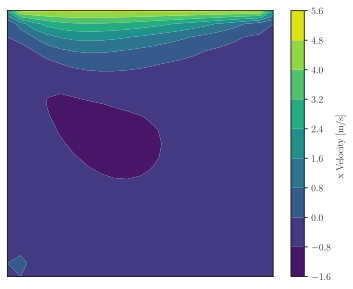

In [146]:
# Plot the x velocity
plt.contourf(u[:,:,nz//2].T)
#plt.imshow(u[:,:,11].T, origin='lower',interpolation='bilinear')
plt.axis('square')
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
plt.colorbar(label='x Velocity [m/s]')
plt.gca().invert_xaxis()
plt.savefig(os.path.join(results_folder, f'{config['output']}_u.pdf'), format='pdf', bbox_inches='tight')
plt.show()

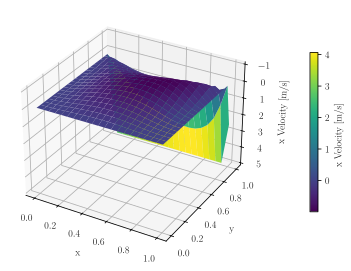

In [147]:
# 3D plot - u on (x,y,0.5)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
nx, ny = u[:,:,11].shape
x = np.linspace(0, 1, nx)
y = np.linspace(0, 1, ny)
X, Y = np.meshgrid(x, y)
Z = u[:,:,11].T
surf = ax.plot_surface(X, Y, Z, cmap='viridis')
fig.colorbar(surf, label='x Velocity [m/s]', shrink=0.6, pad=0.15)
ax.invert_zaxis()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('x Velocity [m/s]')
plt.savefig(os.path.join(results_folder, f'{config['output']}_u_3d.pdf'), format='pdf', bbox_inches='tight')
plt.show()
plt.close()

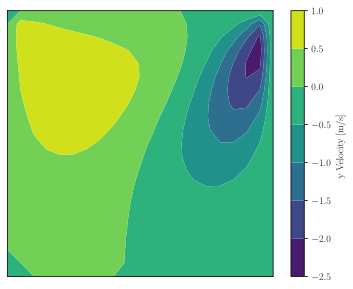

In [148]:
# Plot the y velocity
plt.contourf(v[:,:,nz//2].T)
plt.axis('square')
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
plt.colorbar(label='y Velocity [m/s]')
plt.savefig(os.path.join(results_folder, f'{config['output']}_v.pdf'), format='pdf', bbox_inches='tight')
plt.show()

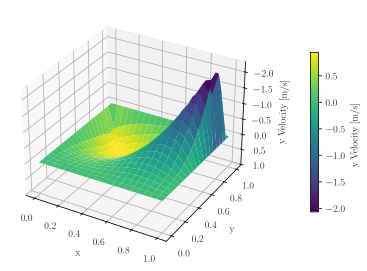

In [149]:
# 3D plot - w on (x,y,0.5)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
nx, ny = v[:,:,11].shape
x = np.linspace(0, 1, nx)
y = np.linspace(0, 1, ny)
X, Y = np.meshgrid(x, y)
Z = v[:,:,11].T
surf = ax.plot_surface(X, Y, Z, cmap='viridis')
fig.colorbar(surf, label='y Velocity [m/s]', shrink=0.6, pad=0.15)
ax.invert_zaxis()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('y Velocity [m/s]')
plt.savefig(os.path.join(results_folder, f'{config['output']}_v_3d.pdf'), format='pdf', bbox_inches='tight')
plt.show()
plt.close()

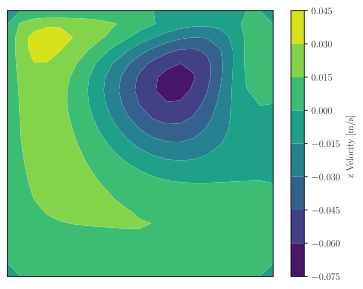

In [150]:
# Plot the z velocity
plt.contourf(w[:,:,11].T)
plt.axis('square')
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
plt.colorbar(label='z Velocity [m/s]')
plt.savefig(os.path.join(results_folder, f'{config['output']}_w.pdf'), format='pdf', bbox_inches='tight')
plt.show()

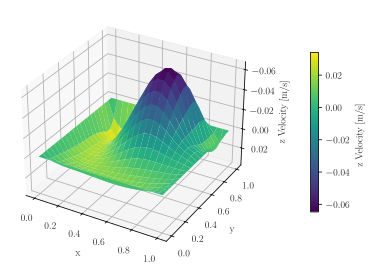

In [151]:
# 3D plot - w on (x,y,0.5)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
nx, ny = w[:,:,11].shape
x = np.linspace(0, 1, nx)
y = np.linspace(0, 1, ny)
X, Y = np.meshgrid(x, y)
Z = w[:,:,11].T
surf = ax.plot_surface(X, Y, Z, cmap='viridis')
fig.colorbar(surf, label='z Velocity [m/s]', shrink=0.6, pad=0.15)
ax.invert_zaxis()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z Velocity [m/s]')
plt.savefig(os.path.join(results_folder, f'{config['output']}_w_3d.pdf'), format='pdf', bbox_inches='tight')
plt.show()
plt.close()

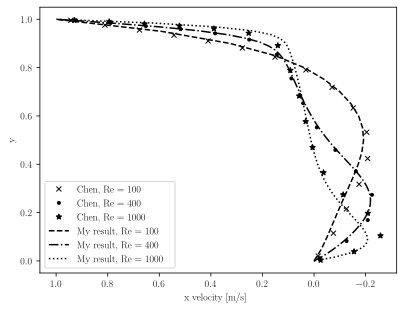

In [162]:
# Centreline Velocities
u_centreline = u[11,:,11]/Ut
y = np.linspace(0,1,len(u_centreline))
chen = pd.read_csv('lit_data/2016_chen_all_results.csv')
myresult = pd.read_csv('results/run11_centreline_u.csv')
myresult400 = pd.read_csv('results/run16_centreline_u.csv')
myresult1000 = pd.read_csv('results/run17_centreline_u.csv')
plt.plot(chen['x100'][::5],chen['Re=100'][::5],'kx',markersize=5,label=f'Chen, Re = 100')
plt.plot(chen['x400'][::5],chen['Re=400'][::5],'ko',markersize=3,label=f'Chen, Re = 400')
plt.plot(chen['x1000'][::5],chen['Re=1000'][::5],'k*',label=f'Chen, Re = 1000')
plt.plot(u_centreline,y,'k--',label=f'My result, Re = {Re:.0f}')
plt.plot(myresult400['u_centreline'],myresult400['y'],'k-.',label=f'My result, Re = 400')
plt.plot(myresult1000['u_centreline'],myresult1000['y'],'k:',label=f'My result, Re = 1000')
plt.legend()
plt.xlabel('x velocity [m/s]')
plt.ylabel('y')
plt.gca().invert_xaxis()
plt.savefig(os.path.join(results_folder, f'{config['output']}_centrelines.pdf'), format='pdf', bbox_inches='tight')
plt.show()

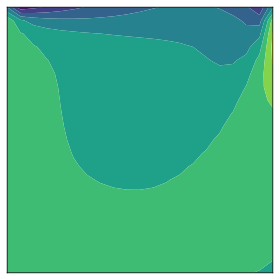

In [153]:
# Plot the z vorticity
plt.contourf(Ωz[:,:,nz//2].T)
plt.axis('square')
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
#plt.colorbar(label='z Vorticity [1/s]')
plt.savefig(os.path.join(results_folder, f'{config['output']}_omegaz.pdf'), format='pdf', bbox_inches='tight')
plt.show()

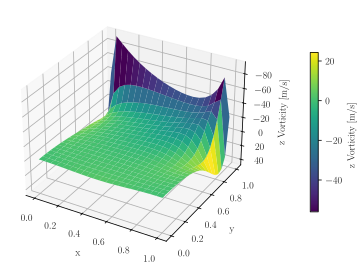

In [154]:
# 3D plot - omegaz on (x,y,0.5)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
nx, ny = Ωz[:,:,11].shape
x = np.linspace(0, 1, nx)
y = np.linspace(0, 1, ny)
X, Y = np.meshgrid(x, y)
Z = Ωz[:,:,11].T
surf = ax.plot_surface(X, Y, Z, cmap='viridis')
fig.colorbar(surf, label='z Vorticity [m/s]', shrink=0.6, pad=0.15)
ax.invert_zaxis()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z Vorticity [m/s]')
plt.savefig(os.path.join(results_folder, f'{config['output']}_zvort_3d.pdf'), format='pdf', bbox_inches='tight')
plt.show()
plt.close()

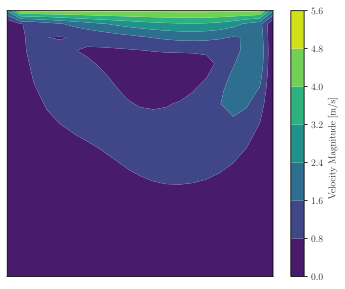

In [155]:
# Velocity magnitude
vel_mag = np.sqrt(u**2 + v**2 + w**2)
plt.contourf(vel_mag[:,:,nz//2].T)
#plt.imshow(vel_mag[:,:,11].T)
plt.axis('square')
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
plt.colorbar(label='Velocity Magnitude [m/s]')
plt.savefig(os.path.join(results_folder, f'{config['output']}_vmag.pdf'), format='pdf', bbox_inches='tight')
plt.show()

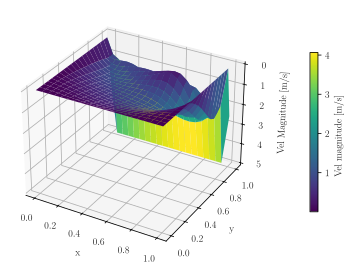

In [156]:
# 3D plot - vel mag on (x,y,0.5)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
nx, ny = vel_mag[:,:,11].shape
x = np.linspace(0, 1, nx)
y = np.linspace(0, 1, ny)
X, Y = np.meshgrid(x, y)
Z = vel_mag[:,:,11].T
surf = ax.plot_surface(X, Y, Z, cmap='viridis')
fig.colorbar(surf, label='Vel magnitude [m/s]', shrink=0.6, pad=0.15)
ax.invert_zaxis()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Vel Magnitude [m/s]')
plt.savefig(os.path.join(results_folder, f'{config['output']}_vel_mag_3d.pdf'), format='pdf', bbox_inches='tight')
plt.show()
plt.close()

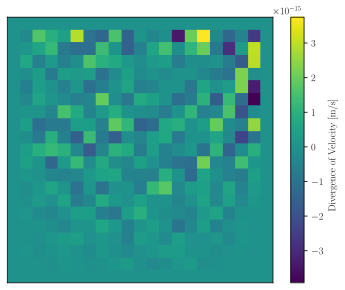

In [157]:
# Divergence of velocity
#plt.contourf(div_vel[:,:,11].T)
plt.imshow(div_vel[:,:,nz//2].T, origin='lower', cmap='viridis')
plt.axis('square')
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
plt.colorbar(label='Divergence of Velocity [m/s]')
plt.savefig(os.path.join(results_folder, f'{config['output']}_div_u.pdf'), format='pdf', bbox_inches='tight')
plt.show()

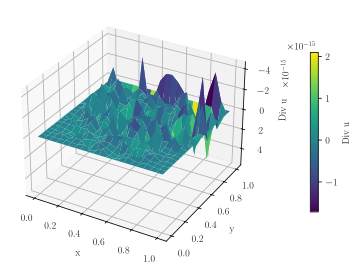

In [158]:
# 3D plot - div u on (x,y,0.5)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
nx, ny = div_vel[:,:,11].shape
x = np.linspace(0, 1, nx)
y = np.linspace(0, 1, ny)
X, Y = np.meshgrid(x, y)
Z = div_vel[:,:,11].T
surf = ax.plot_surface(X, Y, Z, cmap='viridis')
fig.colorbar(surf, label='Div u', shrink=0.6, pad=0.15)
ax.invert_zaxis()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Div u')
plt.savefig(os.path.join(results_folder, f'{config['output']}_div_u_3d.pdf'), format='pdf', bbox_inches='tight')
plt.show()
plt.close()

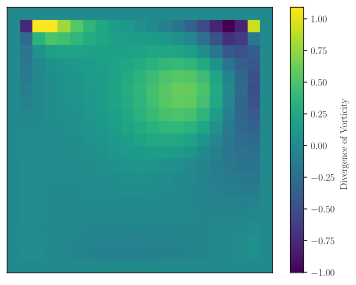

In [159]:
# Divergence of vorticity
plt.imshow(div_Ω[:,:,11].T, origin='lower', cmap='viridis')
plt.axis('square')
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
plt.colorbar(label='Divergence of Vorticity')
plt.savefig(os.path.join(results_folder, f'{config['output']}_div_omega.pdf'), format='pdf', bbox_inches='tight')
plt.show()

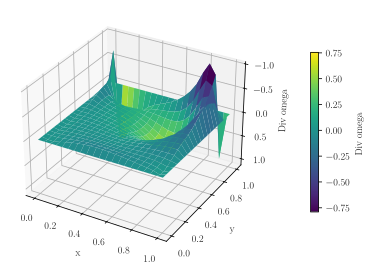

In [160]:
# 3D plot - vel mag on (x,y,0.5)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
nx, ny = div_Ω[:,:,11].shape
x = np.linspace(0, 1, nx)
y = np.linspace(0, 1, ny)
X, Y = np.meshgrid(x, y)
Z = div_Ω[:,:,11].T
surf = ax.plot_surface(X, Y, Z, cmap='viridis')
fig.colorbar(surf, label='Div omega', shrink=0.6, pad=0.15)
ax.invert_zaxis()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Div omega')
plt.savefig(os.path.join(results_folder, f'{config['output']}_div_omega_3d.pdf'), format='pdf', bbox_inches='tight')
plt.show()
plt.close()